# 0. Clone Repo & Install Dependencies

In [1]:
import os
 
# if exist, connect to Google Drive on Colab jupyter notebook
if os.path.exists('/content/drive/MyDrive/git/tensortrade-train'):
  os.chdir('/content/drive/MyDrive/git/tensortrade-train')
elif os.path.exists('/content'):
  from google.colab import drive
  drive.mount('/content/drive')
 
  # Change the current working directory
  os.chdir('/content/drive/MyDrive/git/tensortrade-train')
 
# Print the current working directory
print("Working directory: {0}".format(os.getcwd()))

Working directory: /content/drive/MyDrive/git/tensortrade-train


## 0.1 Clone/update repo

In [2]:
if not os.path.isdir(os.getcwd()+'/.git'):
  !git init && git remote add origin https://github.com/dennislwy/tensortrade-train.git && git pull origin master
else:  # repo already exists, update it
  !git pull origin master

From https://github.com/dennislwy/tensortrade-train
 * branch            master     -> FETCH_HEAD
Already up to date.


## 0.2 Install dependencies
Check GPU availability

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
gpu_available = not (gpu_info.find('failed')>=0 or gpu_info.find('not recognized')>=0 or gpu_info.find('not found')>=0)
gpu_count = 0
if gpu_available:
  print('GPU available')
  print(gpu_info)
  gpu_count = 1
else:
  print('GPU NOT available')
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')

GPU available
Tue Jul 20 08:59:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8     8W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                          

Install requirements

In [4]:
# ipywidgets is required to run Plotly in Jupyter Notebook.
# Uncomment and run the following line to install it if required.

#!pip install ipywidgets

In [5]:
if gpu_available:
  print("Installing GPU requirement packages")
  !pip install -r requirements.ray.txt
else:
  print("Installing non-GPU requirement packages")
  !pip install -r requirements.ray.no-gpu.txt

Installing GPU requirement packages
  Cloning https://github.com/tensortrade-org/tensortrade.git to /tmp/pip-req-build-m2nfm5_a
  Running command git clone -q https://github.com/tensortrade-org/tensortrade.git /tmp/pip-req-build-m2nfm5_a


## Imports

In [6]:
import ta

import pandas as pd
import numpy as np
from tensortrade.feed.core import Stream, DataFeed, NameSpace
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.instruments import USD, BTC
from tensortrade.oms.wallets import Wallet, Portfolio
import tensortrade.env.default as default

%matplotlib inline

## Load Instruments

In [7]:
from tensortrade.oms.instruments import Instrument

TTC = Instrument("TTC", 8, "TensorTrade Coin")

## Data Preparation
### Load data

In [8]:
# sample sine wave data path
sine_fixed_data_path = 'data/inputs/sine-fixed-15m-btc-usdt.csv'
sine_down_data_path = 'data/inputs/sine-down-15m-btc-usdt.csv'
sine_up_data_path = 'data/inputs/sine-up-15m-btc-usdt.csv'

# binance data path
binance_15m_data_path = 'data/inputs/binance-15m-btc-usdt.csv'
binance_1h_data_path = 'data/inputs/binance-1h-btc-usdt.csv'
binance_1d_data_path ='data/inputs/binance-1d-btc-usdt.csv'

In [9]:
def load_data(data_path):
  df = pd.read_csv(data_path)
  df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
  df['date'] = pd.to_datetime(df['date'])
  return df

In [10]:
def generate_sine_series(offset=3300, amplitude=300, steps=1000, cycle=3):
    x = np.arange(0, 2*np.pi, 2*np.pi / (steps+1))
    y = amplitude*np.sin(cycle*x) + offset
    return [x, y]

In [11]:
def generate_sine_data(offset=3300, amplitude=300, steps=1000, cycle=3):
  df = pd.DataFrame()
  [x, y] = generate_sine_series(offset, amplitude, steps, cycle)
  df['close'] = y
  return df

In [12]:
# amp = 50
# offset = 100
 
# offset = 2000
# amp = 1000
 
offset = 33000
amp = 3000
 
steps = 1000
cycle = 3
#df = generate_sine_data(offset=offset, amplitude=amp, steps=steps, cycle=cycle)
#reward_mean_target = 33517.4 # sine offset=33k amp=3k
#expriment_name = "sinewave2"
 
#df = load_data(sine_fixed_data_path)
 
#df = load_data(binance_1h_data_path)
#reward_mean_target = 160000
#expriment_name = "binance_1h"
 
df = load_data(binance_15m_data_path)
reward_mean_target = 270000 # binance-15m
expriment_name = "binance_15m"
 
df

,date,open,high,low,close,volume
0,2021-03-01 00:00:00,45134.11,45480.00,44950.53,45468.40,869.977323
1,2021-03-01 00:15:00,45468.75,46338.22,45431.67,46149.99,1725.032998
2,2021-03-01 00:30:00,46149.99,46571.30,46143.42,46237.33,1493.711587
3,2021-03-01 00:45:00,46238.87,46442.23,46122.24,46217.19,810.852925
4,2021-03-01 01:00:00,46217.18,46343.13,45964.11,46041.44,699.508994
...,...,...,...,...,...,...
12191,2021-07-06 08:15:00,34745.58,34946.67,34714.90,34898.21,1004.526594
12192,2021-07-06 08:30:00,34900.55,34903.50,34806.02,34849.99,399.931849
12193,2021-07-06 08:45:00,34849.99,35118.88,34840.00,34985.78,911.563059
12194,2021-07-06 09:00:00,34985.77,35012.74,34385.67,34505.83,1735.885892


In [13]:
df_sine_fixed = load_data(sine_fixed_data_path)
df_sine_up = load_data(sine_up_data_path)
df_sine_down = load_data(sine_down_data_path)
df_binance_15m = load_data(binance_15m_data_path)
df_binance_1d = load_data(binance_1d_data_path)
df_binance_1h = load_data(binance_1h_data_path)

### Create the dataset features

In [14]:
from ta.trend import *
from transform import difference, log_and_difference, max_min_normalize, mean_normalize

def add_indicators(df, fillna=False):    
    df['close_diff'] = difference(df['close'], inplace=False)
    df['close_log_diff'] = log_and_difference(df['close'], inplace=False)
    df['close_mean'] = mean_normalize(df['close'], inplace=False)
    
    df['macd_diff'] = macd_diff(df['close'], fillna=fillna)
    
    df['ema10'] = ema_indicator(df['close'], 10, fillna=fillna)
    df['ema25'] = ema_indicator(df['close'], 25, fillna=fillna)
    df['ema50'] = ema_indicator(df['close'], 50, fillna=fillna)

    df['ema25_50_diff'] = df['ema25']-df['ema50']
    df['ema25_50_diff_norm'] = 1-df['ema50']/df['ema25']
    df['trend_ema25_50'] = np.where(df['ema25_50_diff']>0, 1, -1)

    df['ema10_25_diff'] = df['ema10']-df['ema25']
    df['ema10_25_diff_norm'] = 1-df['ema25']/df['ema10']
    df['trend_ema10_25'] = np.where(df['ema10_25_diff']>0, 1, -1)

    df.dropna(axis=0, inplace=True)

    df.reset_index(drop=True, inplace=True)

In [15]:
add_indicators(df, fillna=False)

In [16]:
add_indicators(df_sine_fixed, fillna=False)
add_indicators(df_sine_up, fillna=False)
add_indicators(df_sine_down, fillna=False)
add_indicators(df_binance_15m, fillna=False)
add_indicators(df_binance_1d, fillna=False)
add_indicators(df_binance_1h, fillna=False)

In [17]:
total_data_steps = len(df)
print(total_data_steps)
df

12147


,date,open,high,low,close,volume,close_diff,close_log_diff,close_mean,macd_diff,ema10,ema25,ema50,ema25_50_diff,ema25_50_diff_norm,trend_ema25_50,ema10_25_diff,ema10_25_diff_norm,trend_ema10_25
0,2021-03-01 12:15:00,47755.00,47864.50,47450.32,47468.35,739.980951,-286.66,-0.006021,-0.053895,1.004732,47535.784055,47153.585987,46728.740960,424.845027,0.009010,1,382.198068,0.008040,1
1,2021-03-01 12:30:00,47472.40,47858.39,47469.08,47820.80,546.885918,352.45,0.007398,-0.018944,1.441345,47587.605136,47204.910142,46771.566804,433.343338,0.009180,1,382.694994,0.008042,1
2,2021-03-01 12:45:00,47820.81,48044.63,47809.62,47913.80,999.907094,93.00,0.001943,-0.009721,4.369810,47646.913293,47259.440131,46816.360263,443.079868,0.009375,1,387.473162,0.008132,1
3,2021-03-01 13:00:00,47913.80,48319.24,47908.30,48257.87,1183.640364,344.07,0.007155,0.024399,24.719345,47757.996331,47336.242429,46872.890057,463.352372,0.009789,1,421.753902,0.008831,1
4,2021-03-01 13:15:00,48257.88,48441.96,48000.00,48111.09,1725.409799,-146.78,-0.003046,0.009843,23.540073,47822.195180,47395.846088,46921.446917,474.399171,0.010009,1,426.349092,0.008915,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12142,2021-07-06 08:15:00,34745.58,34946.67,34714.90,34898.21,1004.526594,152.63,0.004383,-1.300426,-5.581263,34765.094151,34561.555890,34356.242743,205.313147,0.005941,1,203.538261,0.005855,1
12143,2021-07-06 08:30:00,34900.55,34903.50,34806.02,34849.99,399.931849,-48.22,-0.001383,-1.305208,-8.604038,34780.529760,34583.743130,34375.605380,208.137749,0.006018,1,196.786631,0.005658,1
12144,2021-07-06 08:45:00,34849.99,35118.88,34840.00,34985.78,911.563059,135.79,0.003889,-1.291742,-3.139633,34817.847986,34614.669043,34399.533797,215.135246,0.006215,1,203.178943,0.005835,1
12145,2021-07-06 09:00:00,34985.77,35012.74,34385.67,34505.83,1735.885892,-479.95,-0.013813,-1.339337,-31.930012,34761.117443,34606.296809,34403.702275,202.594533,0.005854,1,154.820634,0.004454,1


### Create Chart Price History Data
Note: It is recommended to create the chart data *after* creating and cleaning the dataset to ensure one-to-one mapping between the historical prices data and the dataset.

In [18]:
if 'volume' in df:
  price_history = df[['date', 'open', 'high', 'low', 'close', 'volume']]
else:
  price_history = df[['close']]

display(price_history.head(3))

,date,open,high,low,close,volume
0,2021-03-01 12:15:00,47755.00,47864.50,47450.32,47468.35,739.980951
1,2021-03-01 12:30:00,47472.40,47858.39,47469.08,47820.80,546.885918
2,2021-03-01 12:45:00,47820.81,48044.63,47809.62,47913.80,999.907094


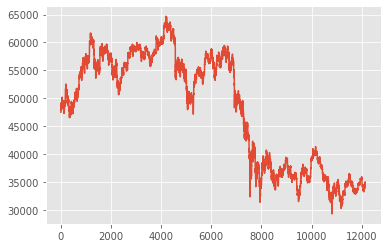

In [19]:
price_history['close'].plot(grid=True)

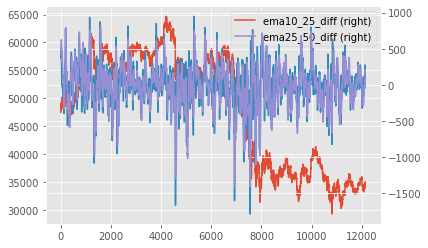

In [20]:
df['close'].plot(grid=True)
df['ema10_25_diff'].plot(grid=True, secondary_y=True, legend=True)
df['ema25_50_diff'].plot(grid=True, secondary_y=True, legend=True)

## Display & Inspect Price History

In [21]:
!pip install mplfinance

In [22]:
if 'volume' in df:
  import mplfinance as mpf
  cd = df.copy()  

  # total data length in dataset
  data_length = len(cd)
  print(f"Total data length: {data_length}")

  cd.set_index('date', inplace=True)

Total data length: 12147


# Calculate Indicators

# Plot Price History Chart

/usr/local/lib/python3.7/dist-packages/mplfinance/_arg_validators.py:45: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  category=UserWarning)


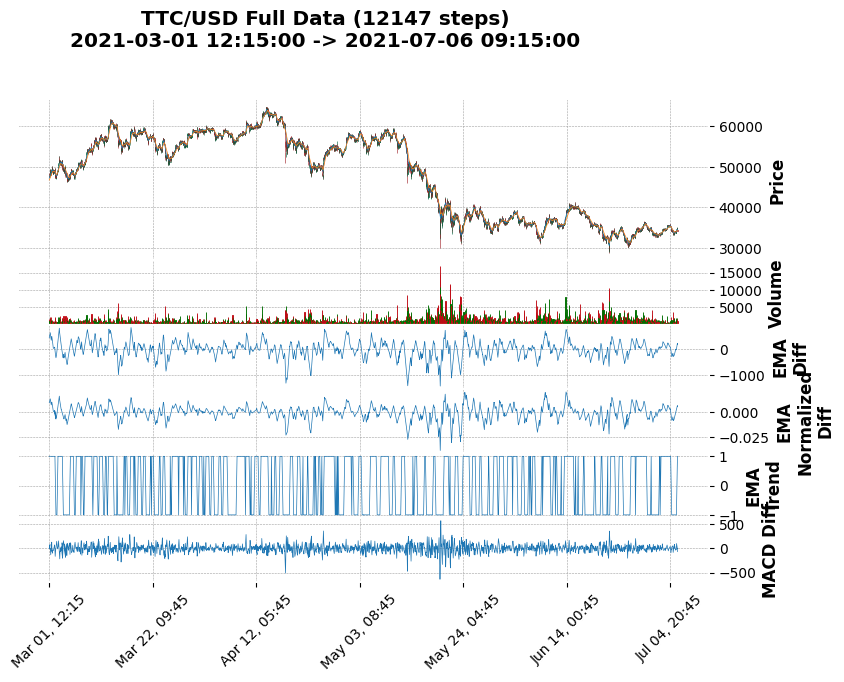

In [23]:
if 'volume' in df:
  overlays = cd[['ema25', 'ema50']]
  apds = [ 
          mpf.make_addplot(overlays, width=0.5), 
          mpf.make_addplot(cd['ema25_50_diff'], panel=2, width=0.5, ylabel='EMA\nDiff'),
          mpf.make_addplot(cd['ema25_50_diff_norm'], panel=3, width=0.5, ylabel='EMA\nNormalized\nDiff'),
          mpf.make_addplot(cd['trend_ema25_50'], panel=4, width=0.5, ylabel='EMA\nTrend'),
          mpf.make_addplot(cd['macd_diff'], panel=5, width=0.5, ylabel='MACD Diff'),
        ]
  mpf.plot(cd, type='candle', 
          title='TTC/USD Full Data (%d steps)\n%s -> %s'  % (data_length, cd.index[0], cd.index[data_length-1]),
          style='charles', volume=True, 
          addplot=apds, figscale=1.2)

In [24]:
import matplotlib.pyplot as plt

def show_chart(title, df, columns1, columns2, columns3, columns4):
    fig, axs = plt.subplots(1, 3, figsize=(16, 6))
    fig.suptitle(title)

    df[columns1].plot(ax=axs[0], grid=True)
    df[columns2].plot(ax=axs[0], grid=True, secondary_y=True)
    df[columns3].plot(ax=axs[1], grid=True)
    df[columns4].plot(ax=axs[2], grid=True)

In [25]:
columns1 = ['close']
columns2 = ['close_diff']
columns3 = ['ema10_25_diff', 'ema25_50_diff', 'macd_diff']
# columns4 = ['trend_ema10_25', 'trend_ema25_50', 'ema10_25_diff_norm', 'ema25_50_diff_norm']
columns4 = ['ema10_25_diff_norm', 'ema25_50_diff_norm']

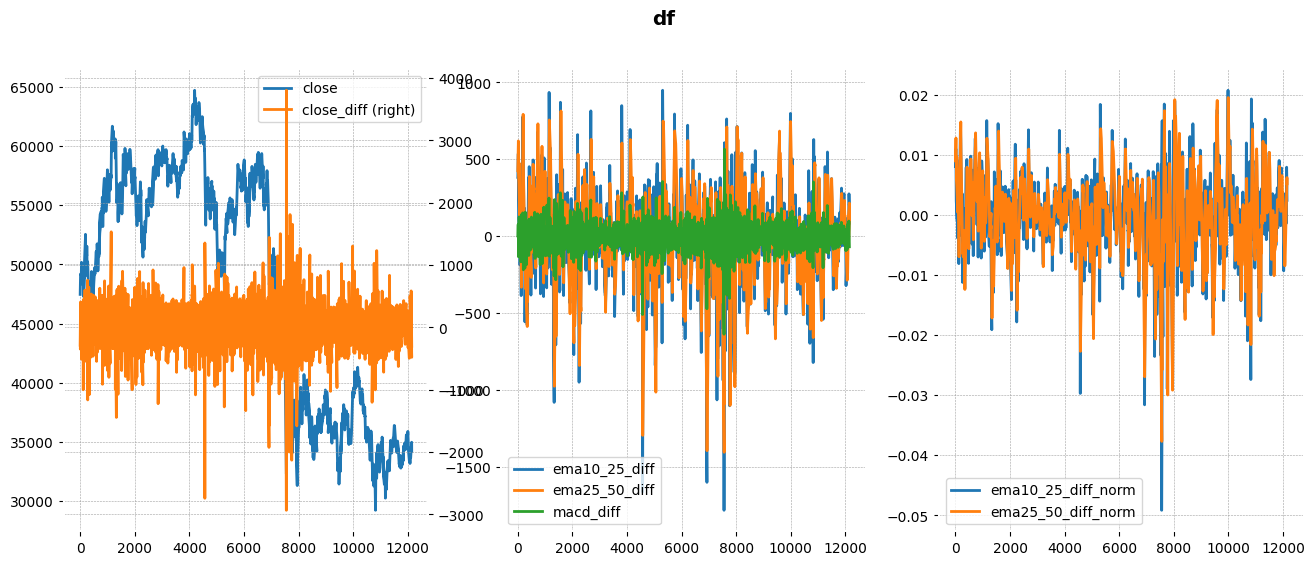

In [26]:
show_chart('df', df, columns1, columns2, columns3, columns4)

### Create Streams

In [27]:
# Setup stream based on 'Close'
close = Stream.source(price_history['close'].tolist(), dtype="float").rename("USD-TTC")

### Create Data Feeds

In [28]:
# feed with all indicators
# with NameSpace("bitfinex"):
#     streams = [Stream.source(dataset[c].tolist(), dtype="float").rename(c) for c in dataset.columns]

# feed = DataFeed(streams)

In [29]:
# feed with custom indicators
# feed = DataFeed([
#     close,
#     close.rolling(window=10).mean().rename("fast"),
#     close.rolling(window=50).mean().rename("medium"),
#     close.rolling(window=100).mean().rename("slow"),
#     close.log().diff().fillna(0).rename("lr")
# ])

In [30]:
feed = DataFeed([
    #Stream.source(df['close'].tolist(), dtype="float").rename("USD-TTC"),
    #Stream.source(df['close'].tolist(), dtype="float").diff().fillna(0).rename("price_diff"),
    #Stream.source(df['close'].tolist(), dtype="float").log().diff().fillna(0).rename("price_log_diff"),
    Stream.source(df['close_diff'].tolist(), dtype="float").rename("close_diff"),

    #Stream.source(df['ema10_25_diff'].tolist(), dtype="float").rename("ema10_25_diff"),
    Stream.source(df['ema10_25_diff_norm'].tolist(), dtype="float").rename("ema10_25_diff_norm"),
    #Stream.source(df['trend_ema10_25'].tolist(), dtype="float").rename("trend_ema10_25"),

    #Stream.source(df['ema25_50_diff'].tolist(), dtype="float").rename("ema25_50_diff"),
    Stream.source(df['ema25_50_diff_norm'].tolist(), dtype="float").rename("ema25_50_diff_norm"),
    #Stream.source(df['trend_ema25_50'].tolist(), dtype="float").rename("trend_ema25_50"),

    Stream.source(df['macd_diff'].tolist(), dtype="float").rename("macd_diff"),
])

In [31]:
# feed = DataFeed([
#     close,
#     close.rolling(window=10).mean().rename("fast"),
#     close.rolling(window=50).mean().rename("medium"),
#     close.rolling(window=100).mean().rename("slow"),
#     close.log().diff().fillna(0).rename("lr")
# ])

In [32]:
feed.next()

{'close_diff': -286.6600000000035,
 'ema10_25_diff_norm': 0.008040218028546597,
 'ema25_50_diff_norm': 0.009009813752225093,
 'macd_diff': 1.0047324834054052}

### Trading Environment Renderers
A renderer is a channel for the trading environment to output its current state. One or more renderers can be attached to the environment at the same time. For example, you can let the environment draw a chart and log to a file at the same time.

Notice that while all renderers can technically be used together, you need to select the best combination to avoid undesired results. For example, PlotlyTradingChart can work well with FileLogger but may not display well with ScreenLogger.

Renderer can be set by name (string) or class, single or list. Available renderers are:
* `'screenlog'` or `ScreenLogger`: Shows results on the screen.
* `'filelog'` or `FileLogger`: Logs results to a file.
* `'plotly'` or `PlotlyTradingChart`: A trading chart based on Plotly.

#### Examples:

* renderers = 'screenlog' (default)
* renderers = ['screenlog', 'filelog']
* renderers = ScreenLogger()
* renderers = ['screenlog', `FileLogger()`]
* renderers = [`FileLogger(filename='example.log')`]

Renderers can also be created and configured first then attached to the environment as seen in a following example.

### Environment with Multiple Renderers
Create PlotlyTradingChart and FileLogger renderers. Configuring renderers is optional as they can be used with their default settings.

With the plotly renderer you must provide an parameter called `renderer_feed`. This is a `DataFeed` instance that provides all the information that is required by a renderer to function.

### Setup Environment

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensortrade.env.generic import Renderer


class PositionChangeChart(Renderer):

    def __init__(self, color: str = "orange"):
        self.color = "orange"

    def render(self, env, **kwargs):
        history = pd.DataFrame(env.observer.renderer_history)

        actions = list(history.action)
        p = list(history.price)

        buy = {}
        sell = {}

        for i in range(len(actions) - 1):
            a1 = actions[i]
            a2 = actions[i + 1]

            if a1 != a2:
                if a1 == 0 and a2 == 1:
                    buy[i] = p[i]
                else:
                    sell[i] = p[i]

        buy = pd.Series(buy)
        sell = pd.Series(sell)

        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        fig.suptitle("Performance")

        axs[0].plot(np.arange(len(p)), p, label="price", color=self.color)
        axs[0].scatter(buy.index, buy.values, marker="^", color="green")
        axs[0].scatter(sell.index, sell.values, marker="^", color="red")
        axs[0].set_title("Trading Chart")

        performance_df = pd.DataFrame().from_dict(env.action_scheme.portfolio.performance, orient='index')
        performance_df.drop(['bitfinex:/USD-TTC'], axis=1, inplace=True)
        performance_df.plot(ax=axs[1])
        axs[1].set_title("Net Worth")

        performance_df.net_worth.plot(ax=axs[0], secondary_y=True, grid=True, legend=True)

        plt.savefig('data/result.png', transparent=False, bbox_inches='tight')
        plt.show()


In [34]:
#from PositionChangeChart import PositionChangeChart
  
def get_price_series():
    x = np.arange(0, 2*np.pi, 2*np.pi / 1001)
    y = 50*np.sin(3*x) + 1000
    return y

def get_exchange(stream):
    return Exchange("bitfinex", service=execute_order)(
        stream
    )

def get_cash_asset(exchange, initial_capital=1000):
    return [
        Wallet(exchange, initial_capital * USD), 
        Wallet(exchange, 0 * TTC)
    ]

initial_capital = 1000

In [35]:
def create_env(config):  
    df = config['df']
    
    p = Stream.source(df['close'].tolist(), dtype="float").rename("USD-TTC")
  
    bitfinex = get_exchange(p)
    
    [cash, asset] = get_cash_asset(bitfinex, initial_capital)

    portfolio = Portfolio(USD, [cash, asset])
    
    reward_scheme = default.rewards.PBR(price=p)
    action_scheme = default.actions.BSH(cash=cash, asset=asset).attach(reward_scheme)

    renderer_feed = DataFeed([
        Stream.source(df['close'].tolist(), dtype="float").rename("price"),
        Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
    ])
    
#     feed = DataFeed([
#         p,
#         p.rolling(window=10).mean().rename("fast"),
#         p.rolling(window=50).mean().rename("medium"),
#         p.rolling(window=100).mean().rename("slow"),
#         p.log().diff().fillna(0).rename("lr")
#     ])
    
    feed = DataFeed([
        #p,
        #p.rolling(window=10).mean().rename("fast"),
        #p.rolling(window=50).mean().rename("medium"),
        #p.rolling(window=100).mean().rename("slow"),
        #p.log().diff().fillna(0).rename("lr")

        Stream.source(df['close_diff'].tolist(), dtype="float").rename("close_diff"),
        #Stream.source(df['close'].tolist(), dtype="float").diff().fillna(0).rename("close_diff"),
        #Stream.source(df['close'].tolist(), dtype="float").log().diff().fillna(0).rename("close_log_diff"),

        Stream.source(df['ema10_25_diff'].tolist(), dtype="float").rename("ema10_25_diff"),
        #Stream.source(df['trend_ema10_25'].tolist(), dtype="float").rename("trend_ema10_25"),

        Stream.source(df['ema25_50_diff'].tolist(), dtype="float").rename("ema25_50_diff"),
        #Stream.source(df['trend_ema25_50'].tolist(), dtype="float").rename("trend_ema25_50"),
        #Stream.source(df['ema25_50_diff_norm'].tolist(), dtype="float").rename("ema25_50_diff_norm"),

        #Stream.source(df['macd_diff'].tolist(), dtype="float").rename("macd_diff"),
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=PositionChangeChart(),
        window_size=config["window_size"],
        max_allowed_loss=0.2
    )
    return environment

## Locate Last Checkpoint (if exist)

In [36]:
from typing import List

# https://github.com/ray-project/ray/issues/4569#issuecomment-809543802
def retrieve_checkpoint(path: str = "data/results", prefix: str = "train_fn") -> str:
    """Returns a latest checkpoint unless there are none, then it returns None."""
    def all_dirs_under(path):
        """Iterates through all files that are under the given path."""
        for cur_path, dirnames, filenames in os.walk(path):
            for dir_ in dirnames:
                yield os.path.join(cur_path, dir_)

    def retrieve_checkpoints(paths: List[str]) -> List[str]:
        checkpoints = list()
        for path in paths:
            for cur_path, dirnames, _ in os.walk(path):
                for dirname in dirnames:
                    if dirname.startswith("checkpoint_"):
                        checkpoints.append(os.path.join(cur_path, dirname))
        return checkpoints

    # sorted_checkpoints = []
    sorted_checkpoints = retrieve_checkpoints(
        sorted(
            filter(
                lambda x: x.startswith(path + "/" + prefix), all_dirs_under(path)
            ),
            key=os.path.getmtime
        )
    )[::-1]

    for checkpoint in sorted_checkpoints:
        if checkpoint is not None:
            return checkpoint + '/checkpoint-' + checkpoint.split('_')[-1]
    return None

In [37]:
lastest_checkpoint_path = retrieve_checkpoint(path="data/results", prefix=expriment_name)
lastest_checkpoint_path

'data/results/binance_15m/PPO_TradingEnv_0_2021-07-20_07-36-02ehp6cvt9/checkpoint_1070/checkpoint-1070'

In [38]:
pause.a()

NameError: ignored

## Setup and Train Agent

In [39]:
import os
import ray
from ray import tune
from ray.tune.registry import register_env
 
register_env("TradingEnv", create_env)
 
analysis = tune.run(
    "PPO",
    name=expriment_name,
    stop={
      "episode_reward_mean": reward_mean_target
    },
    config={
        "env": "TradingEnv",
        "env_config": {
            "window_size": 25,
            "df": df
        },
        "log_level": "DEBUG",
        "framework": "torch",
        "ignore_worker_failures": True,
        "num_workers": os.cpu_count()-1,
        "num_gpus": gpu_count,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    },
    #resume=True,
    restore=lastest_checkpoint_path,
    checkpoint_freq=10,
    checkpoint_at_end=True,
    keep_checkpoints_num=2,
    local_dir="data/results"
)

2021-07-20 09:00:39,967	INFO resource_spec.py:231 -- Starting Ray with 7.37 GiB memory available for workers and up to 3.7 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-07-20 09:00:40,594	INFO services.py:1193 -- View the Ray dashboard at localhost:8265
2021-07-20 09:00:42,669	WARNING worker.py:1134 -- The dashboard on node 6951d155b369 failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/ray/dashboard/dashboard.py", line 961, in <module>
    dashboard.run()
  File "/usr/local/lib/python3.7/dist-packages/ray/dashboard/dashboard.py", line 576, in run
    aiohttp.web.run_app(self.app, host=self.host, port=self.port)
  File "/usr/local/lib/python3.7/dist-packages/aiohttp/web.py", line 508, in run_app
    loop.run_until_complete(main_task)
  File "/usr/lib/python3.7/asyncio/base_events.py", line 587, in run_until_complete
    return future.result()
  File "/usr/lo

Trial name,status,loc
PPO_TradingEnv_f70fe_00000,RUNNING,


(pid=3984) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=3984) Instructions for updating:
(pid=3984) non-resource variables are not supported in the long term
(pid=3984) 2021-07-20 09:00:47,686	DEBUG rollout_worker.py:957 -- Creating policy for default_policy
(pid=3984) 2021-07-20 09:00:47,688	DEBUG catalog.py:471 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f3f5c9d7c90>: Box(-inf, inf, (25, 3), float32) -> (25, 3)
(pid=3984) 2021-07-20 09:00:49,949	INFO rollout_worker.py:990 -- Built policy map: {'default_policy': <ray.rllib.policy.torch_policy_template.PPOTorchPolicy object at 0x7f3f5aaab9d0>}
(pid=3984) 2021-07-20 09:00:49,949	INFO rollout_worker.py:991 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7

Trial name,status,loc
PPO_TradingEnv_f70fe_00000,RUNNING,


(pid=3983) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=3983) Instructions for updating:
(pid=3983) non-resource variables are not supported in the long term
(pid=3983) 2021-07-20 09:00:53,731	DEBUG rollout_worker.py:957 -- Creating policy for default_policy
(pid=3983) 2021-07-20 09:00:53,733	DEBUG catalog.py:471 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f5b739e46d0>: Box(-inf, inf, (25, 3), float32) -> (25, 3)
(pid=3983) 2021-07-20 09:00:53,757	DEBUG rollout_worker.py:415 -- Creating policy evaluation worker 1 on CPU (please ignore any CUDA init errors)
(pid=3983) 2021-07-20 09:00:53,758	DEBUG rollout_worker.py:540 -- Created rollout worker with env <ray.rllib.env.base_env._VectorEnvToBaseEnv object at 0x7f5b7133fdd0> (<TradingEnv instance>), policies {'de

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-01-06
  done: false
  episode_len_mean: 158.70833333333334
  episode_reward_max: 9080.070000000014
  episode_reward_mean: -11.936666666657402
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 24
  episodes_total: 2712
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.2
        cur_lr: 8.0e-06
        entropy: 0.2234450913965702
        entropy_coeff: 0.01
        kl: 2.2173299826681614
        policy_loss: -0.2304413424571976
        total_loss: 0.6992939338088036
        vf_explained_var: 0.021133743226528168
        vf_loss: 0.9770074505358934
    num_steps_sampled: 4284000
    num_steps_trained: 4284000
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 58.2875
    

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1071,17149.1,4284000,-11.9367


(pid=3984) 2021-07-20 09:01:14,008	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.30000000000000004, 'cur_lr': 6.716000000000001e-07, 'total_loss': 0.23089745896868408, 'policy_loss': -0.030309749068692327, 'vf_loss': 0.520868519321084, 'vf_explained_var': 0.22616369, 'kl': 0.005372083509459495, 'entropy': 0.0838676888961345, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:01:14,183	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.30000000000000004, 'cur_lr': 6.716000000000001e-07, 'total_loss': 0.17247677664272487, 'policy_loss': -0.05804455737234093, 'vf_loss': 0.4523515971377492, 'vf_explained_var': 0.26491314, 'kl': 0.0168905181781156, 'entropy': 0.07216230989433825, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:01:14,372	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.30000000000000004, 'cur_lr': 6.716000000000001e-07, 'total_loss': 0.1434380438295193, 'policy_loss': -0.06471808830974624, 'vf_loss': 0.4058932550251484, 'vf

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-01-19
  done: false
  episode_len_mean: 259.5925925925926
  episode_reward_max: 195070.58999999973
  episode_reward_mean: 15488.85037037036
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 3
  episodes_total: 2715
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.30000000000000004
        cur_lr: 6.716000000000001e-07
        entropy: 0.07841241615824401
        entropy_coeff: 0.01
        kl: 0.013639513141242787
        policy_loss: -0.06924428686033934
        total_loss: 0.0388720920891501
        vf_explained_var: 0.4416233003139496
        vf_loss: 0.20961729483678937
    num_steps_sampled: 4288000
    num_steps_trained: 4288000
  iterations_since_restore: 2
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    

(pid=3984) 2021-07-20 09:01:19,398	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.30000000000000004, 'cur_lr': 6.716000000000001e-07, 'total_loss': 0.0388720920891501, 'policy_loss': -0.06924428686033934, 'vf_loss': 0.20961729483678937, 'vf_explained_var': 0.4416233, 'kl': 0.013639513141242787, 'entropy': 0.07841241615824401, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:01:19,405	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 1549.0x the scale of `vf_clip_param`. This means that it will take more than 1549.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=3984) 2021-07-20 09:01:19,408	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4290721, mean_mean=47.80039870328814, mean_std=279.34547806209764), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1072,17162.1,4288000,15488.9


(pid=3984) 2021-07-20 09:01:27,646	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.30000000000000004, 'cur_lr': 6.712e-07, 'total_loss': 0.06204986397642642, 'policy_loss': -0.010956479120068252, 'vf_loss': 0.1431141115608625, 'vf_explained_var': 0.65672356, 'kl': 0.00698851193211932, 'entropy': 0.06472651602234691, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:01:27,839	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.30000000000000004, 'cur_lr': 6.712e-07, 'total_loss': 0.033903964154887944, 'policy_loss': -0.040374735777731985, 'vf_loss': 0.14033476053737104, 'vf_explained_var': 0.6633048, 'kl': 0.015421153046190739, 'entropy': 0.05150270415470004, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:01:28,041	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.30000000000000004, 'cur_lr': 6.712e-07, 'total_loss': 0.016636461834423244, 'policy_loss': -0.05376660660840571, 'vf_loss': 0.13174738734960556, 'vf_explained_var': 0.6675735, 

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-01-33
  done: false
  episode_len_mean: 358.3103448275862
  episode_reward_max: 238508.5299999997
  episode_reward_mean: 30608.91413793101
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 2
  episodes_total: 2717
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.30000000000000004
        cur_lr: 6.712e-07
        entropy: 0.05630072706844658
        entropy_coeff: 0.01
        kl: 0.009548218789859675
        policy_loss: -0.051976576214656234
        total_loss: 0.009749733260832727
        vf_explained_var: 0.7071534395217896
        vf_loss: 0.11884970881510526
    num_steps_sampled: 4292000
    num_steps_trained: 4292000
  iterations_since_restore: 3
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_p

(pid=3984) 2021-07-20 09:01:33,530	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.30000000000000004, 'cur_lr': 6.712e-07, 'total_loss': 0.009749733260832727, 'policy_loss': -0.051976576214656234, 'vf_loss': 0.11884970881510526, 'vf_explained_var': 0.70715344, 'kl': 0.009548218789859675, 'entropy': 0.05630072706844658, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:01:33,538	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 3061.0x the scale of `vf_clip_param`. This means that it will take more than 3061.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=3984) 2021-07-20 09:01:33,541	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4294723, mean_mean=47.79587094190457, mean_std=279.35908430188823), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1073,17176.1,4292000,30608.9


(pid=3984) 2021-07-20 09:01:41,949	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.30000000000000004, 'cur_lr': 6.708e-07, 'total_loss': 0.030593590505304746, 'policy_loss': -0.014964670350309461, 'vf_loss': 0.09041511995019391, 'vf_explained_var': 0.7457382, 'kl': 0.002871687992699209, 'entropy': 0.05108055012533441, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:01:42,136	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.30000000000000004, 'cur_lr': 6.708e-07, 'total_loss': 0.009581170306773856, 'policy_loss': -0.037624441931257024, 'vf_loss': 0.08948642283212394, 'vf_explained_var': 0.7554203, 'kl': 0.009487077542871702, 'entropy': 0.03837231145007536, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:01:42,339	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.30000000000000004, 'cur_lr': 6.708e-07, 'total_loss': -0.0020015267946291715, 'policy_loss': -0.047463962400797755, 'vf_loss': 0.08647643684525974, 'vf_explained_var': 0.7041

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-01-47
  done: false
  episode_len_mean: 488.25
  episode_reward_max: 252990.20999999993
  episode_reward_mean: 50784.12218749997
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 3
  episodes_total: 2720
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.30000000000000004
        cur_lr: 6.708e-07
        entropy: 0.04089914192445576
        entropy_coeff: 0.01
        kl: 0.0062882799793442246
        policy_loss: -0.048840706585906446
        total_loss: -0.009707278804853559
        vf_explained_var: 0.7918300628662109
        vf_loss: 0.07531186944106594
    num_steps_sampled: 4296000
    num_steps_trained: 4296000
  iterations_since_restore: 4
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 

(pid=3984) 2021-07-20 09:01:47,711	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.30000000000000004, 'cur_lr': 6.708e-07, 'total_loss': -0.009707278804853559, 'policy_loss': -0.048840706585906446, 'vf_loss': 0.07531186944106594, 'vf_explained_var': 0.79183006, 'kl': 0.0062882799793442246, 'entropy': 0.04089914192445576, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:01:47,718	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 5078.0x the scale of `vf_clip_param`. This means that it will take more than 5078.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=3984) 2021-07-20 09:01:47,721	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4298726, mean_mean=47.79173016998924, mean_std=279.36275836420987), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1074,17190.2,4296000,50784.1


(pid=3983) 2021-07-20 09:01:54,131	INFO sampler.py:714 -- Preprocessed obs: np.ndarray((25, 3), dtype=float32, min=-409.25, max=279.7, mean=110.912)
(pid=3983) 2021-07-20 09:01:54,132	INFO sampler.py:719 -- Filtered obs: np.ndarray((25, 3), dtype=float64, min=-1.779, max=1.171, mean=0.21)
(pid=3983) 2021-07-20 09:01:54,132	INFO sampler.py:882 -- Inputs to compute_actions():
(pid=3983) 
(pid=3983) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=3983)                                   'env_id': 0,
(pid=3983)                                   'info': { 'net_worth': 811.0434509345,
(pid=3983)                                             'step': 1742},
(pid=3983)                                   'obs': np.ndarray((25, 3), dtype=float64, min=-1.779, max=1.171, mean=0.21),
(pid=3983)                                   'prev_action': 1,
(pid=3983)                                   'prev_reward': -79.43000000000029,
(pid=3983)                                   'rnn_state': []},
(pid

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-02-01
  done: false
  episode_len_mean: 562.7058823529412
  episode_reward_max: 252990.20999999993
  episode_reward_mean: 62583.2308823529
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 2
  episodes_total: 2722
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.30000000000000004
        cur_lr: 6.704e-07
        entropy: 0.02857232664246112
        entropy_coeff: 0.01
        kl: 0.004205291967082303
        policy_loss: -0.03157538501545787
        total_loss: -0.012280171096790582
        vf_explained_var: 0.8869496583938599
        vf_loss: 0.036638701654737815
    num_steps_sampled: 4300000
    num_steps_trained: 4300000
  iterations_since_restore: 5
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_

(pid=3984) 2021-07-20 09:02:01,498	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.30000000000000004, 'cur_lr': 6.704e-07, 'total_loss': -0.012280171096790582, 'policy_loss': -0.03157538501545787, 'vf_loss': 0.036638701654737815, 'vf_explained_var': 0.88694966, 'kl': 0.004205291967082303, 'entropy': 0.02857232664246112, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:02:01,506	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 6258.0x the scale of `vf_clip_param`. This means that it will take more than 6258.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=3984) 2021-07-20 09:02:01,509	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4302728, mean_mean=47.79688009630723, mean_std=279.36001852692993), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1075,17203.8,4300000,62583.2


(pid=3984) 2021-07-20 09:02:09,505	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.15000000000000002, 'cur_lr': 6.699999999999999e-07, 'total_loss': 0.02100556273944676, 'policy_loss': 0.006544783187564462, 'vf_loss': 0.02920722099224804, 'vf_explained_var': 0.91107523, 'kl': 0.0009778839446477477, 'entropy': 0.02895166474627331, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:02:09,682	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.15000000000000002, 'cur_lr': 6.699999999999999e-07, 'total_loss': -0.0016483486106153578, 'policy_loss': -0.01603005127981305, 'vf_loss': 0.02865448327793274, 'vf_explained_var': 0.8499901, 'kl': 0.00204263512569014, 'entropy': 0.025193278881488368, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:02:09,868	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.15000000000000002, 'cur_lr': 6.699999999999999e-07, 'total_loss': -0.0005652427498716861, 'policy_loss': -0.014793810958508402, 'vf_loss': 0.02816788

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-02-15
  done: false
  episode_len_mean: 632.3333333333334
  episode_reward_max: 262920.74999999977
  episode_reward_mean: 73615.01555555551
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 2
  episodes_total: 2724
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.15000000000000002
        cur_lr: 6.699999999999999e-07
        entropy: 0.024429954966763034
        entropy_coeff: 0.01
        kl: 0.0025967731526179705
        policy_loss: -0.022299418225884438
        total_loss: -0.011020647420082241
        vf_explained_var: 0.9325472116470337
        vf_loss: 0.022267109830863774
    num_steps_sampled: 4304000
    num_steps_trained: 4304000
  iterations_since_restore: 6
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  per

(pid=3984) 2021-07-20 09:02:15,032	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.15000000000000002, 'cur_lr': 6.699999999999999e-07, 'total_loss': -0.011020647420082241, 'policy_loss': -0.022299418225884438, 'vf_loss': 0.022267109830863774, 'vf_explained_var': 0.9325472, 'kl': 0.0025967731526179705, 'entropy': 0.024429954966763034, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:02:15,040	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 7362.0x the scale of `vf_clip_param`. This means that it will take more than 7362.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=3984) 2021-07-20 09:02:15,044	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4306730, mean_mean=47.801871153017125, mean_std=279.3599326294331), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1076,17217.2,4304000,73615


(pid=3984) 2021-07-20 09:02:23,299	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.07500000000000001, 'cur_lr': 6.695999999999999e-07, 'total_loss': 0.030330133042298257, 'policy_loss': 0.020070691127330065, 'vf_loss': 0.020619637427444104, 'vf_explained_var': 0.93014354, 'kl': 0.0030081656956604773, 'entropy': 0.027598736283835024, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:02:23,492	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.07500000000000001, 'cur_lr': 6.695999999999999e-07, 'total_loss': 0.05210722459014505, 'policy_loss': 0.04167038890591357, 'vf_loss': 0.020398803022544598, 'vf_explained_var': 0.93555737, 'kl': 0.008217397982662078, 'entropy': 0.03788753965636715, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:02:23,692	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.07500000000000001, 'cur_lr': 6.695999999999999e-07, 'total_loss': 0.003499211190501228, 'policy_loss': -0.006395220087142661, 'vf_loss': 0.019887598

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-02-28
  done: false
  episode_len_mean: 691.3684210526316
  episode_reward_max: 262920.74999999977
  episode_reward_mean: 83135.5684210526
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 2
  episodes_total: 2726
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.07500000000000001
        cur_lr: 6.695999999999999e-07
        entropy: 0.02261535034631379
        entropy_coeff: 0.01
        kl: 0.001268538700969657
        policy_loss: -0.01831435243366286
        total_loss: -0.010604023176711053
        vf_explained_var: 0.9553753137588501
        vf_loss: 0.015682680779718794
    num_steps_sampled: 4308000
    num_steps_trained: 4308000
  iterations_since_restore: 7
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
 

(pid=3984) 2021-07-20 09:02:28,751	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.07500000000000001, 'cur_lr': 6.695999999999999e-07, 'total_loss': -0.010604023176711053, 'policy_loss': -0.01831435243366286, 'vf_loss': 0.015682680779718794, 'vf_explained_var': 0.9553753, 'kl': 0.001268538700969657, 'entropy': 0.02261535034631379, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:02:28,759	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 8314.0x the scale of `vf_clip_param`. This means that it will take more than 8314.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=3984) 2021-07-20 09:02:28,762	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4310732, mean_mean=47.791555330860284, mean_std=279.3697451973323), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1077,17230.8,4308000,83135.6


(pid=3984) 2021-07-20 09:02:36,954	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.037500000000000006, 'cur_lr': 6.691999999999999e-07, 'total_loss': 0.022925555240362883, 'policy_loss': 0.0026612916844896972, 'vf_loss': 0.04100304147868883, 'vf_explained_var': 0.8737771, 'kl': 0.0006652067991617383, 'entropy': 0.026220570725854486, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:02:37,145	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.037500000000000006, 'cur_lr': 6.691999999999999e-07, 'total_loss': 0.0031890040554571897, 'policy_loss': -0.01678806936251931, 'vf_loss': 0.040300228269188665, 'vf_explained_var': 0.8698386, 'kl': 0.0016762557243055198, 'entropy': 0.02359016047557816, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:02:37,343	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.037500000000000006, 'cur_lr': 6.691999999999999e-07, 'total_loss': -0.006083559652324766, 'policy_loss': -0.025847298034932464, 'vf_loss': 0.039

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-02-42
  done: false
  episode_len_mean: 772.780487804878
  episode_reward_max: 262920.74999999977
  episode_reward_mean: 96076.80487804873
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 3
  episodes_total: 2729
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.037500000000000006
        cur_lr: 6.691999999999999e-07
        entropy: 0.022643004776909947
        entropy_coeff: 0.01
        kl: 0.001680686787040031
        policy_loss: -0.03922277071978897
        total_loss: -0.02197073958814144
        vf_explained_var: 0.8805739879608154
        vf_loss: 0.03483087209315272
    num_steps_sampled: 4312000
    num_steps_trained: 4312000
  iterations_since_restore: 8
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
 

(pid=3984) 2021-07-20 09:02:42,839	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.037500000000000006, 'cur_lr': 6.691999999999999e-07, 'total_loss': -0.02197073958814144, 'policy_loss': -0.03922277071978897, 'vf_loss': 0.03483087209315272, 'vf_explained_var': 0.880574, 'kl': 0.001680686787040031, 'entropy': 0.022643004776909947, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:02:42,849	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 9608.0x the scale of `vf_clip_param`. This means that it will take more than 9608.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=3984) 2021-07-20 09:02:42,852	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4314735, mean_mean=47.79156142639351, mean_std=279.36873617001123), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1078,17244.8,4312000,96076.8


(pid=3984) 2021-07-20 09:02:51,605	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.018750000000000003, 'cur_lr': 6.688e-07, 'total_loss': 0.007336461319937371, 'policy_loss': 0.0006333479395834729, 'vf_loss': 0.013827119200868765, 'vf_explained_var': 0.95441985, 'kl': 0.0006445871275081901, 'entropy': 0.022253105678828433, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:02:51,797	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.018750000000000003, 'cur_lr': 6.688e-07, 'total_loss': 0.006333686033030972, 'policy_loss': -0.0017052024777512997, 'vf_loss': 0.016434575394669082, 'vf_explained_var': 0.9423734, 'kl': 0.001698215432043071, 'entropy': 0.02102410391671583, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:02:52,000	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.018750000000000003, 'cur_lr': 6.688e-07, 'total_loss': -0.0055473933316534385, 'policy_loss': -0.01183984539238736, 'vf_loss': 0.012948532414156944, 'vf_explained_var

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-02-57
  done: false
  episode_len_mean: 821.7441860465116
  episode_reward_max: 267489.59999999974
  episode_reward_mean: 103842.80883720926
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 2
  episodes_total: 2731
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.018750000000000003
        cur_lr: 6.688e-07
        entropy: 0.022305592603515834
        entropy_coeff: 0.01
        kl: 0.0012343329062787234
        policy_loss: -0.013077132374746725
        total_loss: -0.008356655365787446
        vf_explained_var: 0.9019541144371033
        vf_loss: 0.00984077742032241
    num_steps_sampled: 4316000
    num_steps_trained: 4316000
  iterations_since_restore: 9
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_


(pid=3984) 2021-07-20 09:02:57,370	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 10384.0x the scale of `vf_clip_param`. This means that it will take more than 10384.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=3984) 2021-07-20 09:02:57,373	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4318737, mean_mean=47.78800585664126, mean_std=279.36564598506396), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=3983) 2021-07-20 09:02:57,490	INFO sampler.py:882 -- Inputs to compute_actions():
(pid=3983) 
(pid=3983) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=3983)                                   'env_id': 0,
(pid=3983)                                   'info': { 'net_worth': 1093.78,
(pid=3983)                                             'step': 665},
(pid=3983)                                   'obs': np.ndarray((25, 3),

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1079,17259,4316000,103843


(pid=3983) 2021-07-20 09:02:57,891	INFO sample_batch_builder.py:204 -- Trajectory fragment after postprocess_trajectory():
(pid=3983) 
(pid=3983) { 'agent0': { 'data': { 'action_dist_inputs': np.ndarray((200, 2), dtype=float32, min=-18.545, max=18.538, mean=0.002),
(pid=3983)                         'action_logp': np.ndarray((200,), dtype=float32, min=-0.07, max=0.0, mean=-0.004),
(pid=3983)                         'action_prob': np.ndarray((200,), dtype=float32, min=0.932, max=1.0, mean=0.996),
(pid=3983)                         'actions': np.ndarray((200,), dtype=int64, min=0.0, max=1.0, mean=0.545),
(pid=3983)                         'advantages': np.ndarray((200,), dtype=float32, min=-0.076, max=0.175, mean=0.004),
(pid=3983)                         'agent_index': np.ndarray((200,), dtype=int64, min=0.0, max=0.0, mean=0.0),
(pid=3983)                         'dones': np.ndarray((200,), dtype=bool, min=0.0, max=0.0, mean=0.0),
(pid=3983)                         'eps_id': np.ndarray(

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-03-10
  done: false
  episode_len_mean: 863.7777777777778
  episode_reward_max: 267489.59999999974
  episode_reward_mean: 110604.98799999994
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 2
  episodes_total: 2733
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.009375000000000001
        cur_lr: 6.684e-07
        entropy: 0.018557834293460473
        entropy_coeff: 0.01
        kl: 0.0009130772286880529
        policy_loss: -0.012282307798159309
        total_loss: -0.004981648380635306
        vf_explained_var: 0.9542396068572998
        vf_loss: 0.014955353162804386
    num_steps_sampled: 4320000
    num_steps_trained: 4320000
  iterations_since_restore: 10
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cp

(pid=3984) 2021-07-20 09:03:10,983	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.009375000000000001, 'cur_lr': 6.684e-07, 'total_loss': -0.004981648380635306, 'policy_loss': -0.012282307798159309, 'vf_loss': 0.014955353162804386, 'vf_explained_var': 0.9542396, 'kl': 0.0009130772286880529, 'entropy': 0.018557834293460473, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:03:10,994	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 11060.0x the scale of `vf_clip_param`. This means that it will take more than 11060.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=3984) 2021-07-20 09:03:10,997	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4322739, mean_mean=47.792598128710914, mean_std=279.36460586500976), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1080,17272.5,4320000,110605


(pid=3984) 2021-07-20 09:03:19,129	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.004687500000000001, 'cur_lr': 6.68e-07, 'total_loss': 0.02208891953341663, 'policy_loss': 0.010799559997394681, 'vf_loss': 0.022984960094618145, 'vf_explained_var': 0.92358696, 'kl': 0.0006443426414416108, 'entropy': 0.020614079636288807, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:03:19,309	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.004687500000000001, 'cur_lr': 6.68e-07, 'total_loss': 0.0534661611309275, 'policy_loss': 0.04397495079319924, 'vf_loss': 0.019521379963407526, 'vf_explained_var': 0.93952924, 'kl': 0.0060736384002666455, 'entropy': 0.02979482989758253, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:03:19,505	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.004687500000000001, 'cur_lr': 6.68e-07, 'total_loss': -0.008900052693206817, 'policy_loss': -0.01829777139937505, 'vf_loss': 0.01919803038617829, 'vf_explained_var': 0.94111

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-03-24
  done: false
  episode_len_mean: 904.6170212765958
  episode_reward_max: 267603.7599999997
  episode_reward_mean: 117113.64446808505
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 2
  episodes_total: 2735
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.004687500000000001
        cur_lr: 6.68e-07
        entropy: 0.0215991816658061
        entropy_coeff: 0.01
        kl: 0.0021108302389620803
        policy_loss: -0.009667748992796987
        total_loss: -0.0010227559541817755
        vf_explained_var: 0.9456772804260254
        vf_loss: 0.017702181707136333
    num_steps_sampled: 4324000
    num_steps_trained: 4324000
  iterations_since_restore: 11
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_u

(pid=3984) 2021-07-20 09:03:24,941	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.004687500000000001, 'cur_lr': 6.68e-07, 'total_loss': -0.0010227559541817755, 'policy_loss': -0.009667748992796987, 'vf_loss': 0.017702181707136333, 'vf_explained_var': 0.9456773, 'kl': 0.0021108302389620803, 'entropy': 0.0215991816658061, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:03:24,949	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 11711.0x the scale of `vf_clip_param`. This means that it will take more than 11711.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=3984) 2021-07-20 09:03:24,951	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4326741, mean_mean=47.78591892600894, mean_std=279.37269459121126), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1081,17286.2,4324000,117114


(pid=3984) 2021-07-20 09:03:33,246	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0023437500000000003, 'cur_lr': 6.676e-07, 'total_loss': 0.006251258251722902, 'policy_loss': -0.003956679138354957, 'vf_loss': 0.020878033246845007, 'vf_explained_var': 0.8774109, 'kl': 0.0005104399035967058, 'entropy': 0.02322732756147161, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:03:33,427	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0023437500000000003, 'cur_lr': 6.676e-07, 'total_loss': -0.002001420856686309, 'policy_loss': -0.011913747322978452, 'vf_loss': 0.020237283657479566, 'vf_explained_var': 0.94585466, 'kl': 0.0019867247556248913, 'entropy': 0.021097019780427217, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:03:33,624	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0023437500000000003, 'cur_lr': 6.676e-07, 'total_loss': -0.012507444014772773, 'policy_loss': -0.02224834347725846, 'vf_loss': 0.019913042908228817, 'vf_explained_

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-03-38
  done: false
  episode_len_mean: 959.82
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 125869.49099999994
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 3
  episodes_total: 2738
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.0023437500000000003
        cur_lr: 6.676e-07
        entropy: 0.020552656467771158
        entropy_coeff: 0.01
        kl: 0.0016864420631463872
        policy_loss: -0.018730072741163895
        total_loss: -0.011071075801737607
        vf_explained_var: 0.9489089250564575
        vf_loss: 0.01572114517330192
    num_steps_sampled: 4328000
    num_steps_trained: 4328000
  iterations_since_restore: 12
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_perce

(pid=3984) 2021-07-20 09:03:38,711	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0023437500000000003, 'cur_lr': 6.676e-07, 'total_loss': -0.011071075801737607, 'policy_loss': -0.018730072741163895, 'vf_loss': 0.01572114517330192, 'vf_explained_var': 0.9489089, 'kl': 0.0016864420631463872, 'entropy': 0.020552656467771158, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:03:38,720	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 12587.0x the scale of `vf_clip_param`. This means that it will take more than 12587.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=3984) 2021-07-20 09:03:38,722	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4330744, mean_mean=47.786120505509416, mean_std=279.37009593198144), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1082,17299.8,4328000,125869


(pid=3984) 2021-07-20 09:03:47,327	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0011718750000000002, 'cur_lr': 6.671999999999999e-07, 'total_loss': 0.04667968352441676, 'policy_loss': 0.038406188163207844, 'vf_loss': 0.016996508402371546, 'vf_explained_var': 0.9436379, 'kl': 0.0013682142508173803, 'entropy': 0.022635557601461187, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:03:47,526	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0011718750000000002, 'cur_lr': 6.671999999999999e-07, 'total_loss': 0.002535665757022798, 'policy_loss': -0.006739780190400779, 'vf_loss': 0.019288254996354226, 'vf_explained_var': 0.9380024, 'kl': 0.011803327227426053, 'entropy': 0.03825129312463105, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:03:47,724	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0011718750000000002, 'cur_lr': 6.671999999999999e-07, 'total_loss': -0.007973059648065828, 'policy_loss': -0.015583184082061052, 'vf_loss': 0.01

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-03-53
  done: false
  episode_len_mean: 991.6538461538462
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 130991.11980769224
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 2
  episodes_total: 2740
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.0011718750000000002
        cur_lr: 6.671999999999999e-07
        entropy: 0.026158912805840373
        entropy_coeff: 0.01
        kl: 0.0039153876095952
        policy_loss: -0.01490066185942851
        total_loss: -0.009115054097492248
        vf_explained_var: 0.8949416875839233
        vf_loss: 0.012085213129466865
    num_steps_sampled: 4332000
    num_steps_trained: 4332000
  iterations_since_restore: 13
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf

(pid=3984) 2021-07-20 09:03:53,326	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0011718750000000002, 'cur_lr': 6.671999999999999e-07, 'total_loss': -0.009115054097492248, 'policy_loss': -0.01490066185942851, 'vf_loss': 0.012085213129466865, 'vf_explained_var': 0.8949417, 'kl': 0.0039153876095952, 'entropy': 0.026158912805840373, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:03:53,334	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 13099.0x the scale of `vf_clip_param`. This means that it will take more than 13099.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=3984) 2021-07-20 09:03:53,336	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4334746, mean_mean=47.78298227472848, mean_std=279.37312654124895), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1083,17314.3,4332000,130991


(pid=3983) 2021-07-20 09:03:57,899	INFO sampler.py:510 -- Raw obs from env: { 0: { 'agent0': np.ndarray((25, 3), dtype=float32, min=-309.05, max=474.26, mean=121.833)}}
(pid=3983) 2021-07-20 09:03:57,899	INFO sampler.py:511 -- Info return from env: {0: {'agent0': {'net_worth': 1092.68, 'step': 862}}}
(pid=3983) 2021-07-20 09:03:57,899	INFO sampler.py:714 -- Preprocessed obs: np.ndarray((25, 3), dtype=float32, min=-309.05, max=474.26, mean=121.833)
(pid=3983) 2021-07-20 09:03:57,899	INFO sampler.py:719 -- Filtered obs: np.ndarray((25, 3), dtype=float64, min=-1.35, max=2.006, mean=0.274)
(pid=3983) 2021-07-20 09:03:57,900	INFO sampler.py:882 -- Inputs to compute_actions():
(pid=3983) 
(pid=3983) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=3983)                                   'env_id': 0,
(pid=3983)                                   'info': { 'net_worth': 1092.68,
(pid=3983)                                             'step': 862},
(pid=3983)                           

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-04-07
  done: false
  episode_len_mean: 1019.4074074074074
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 135563.4351851851
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 2
  episodes_total: 2742
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.0005859375000000001
        cur_lr: 6.667999999999999e-07
        entropy: 0.02024141640868038
        entropy_coeff: 0.01
        kl: 0.002218025232650689
        policy_loss: -0.02453016774961725
        total_loss: -0.013664637226611376
        vf_explained_var: 0.9306625127792358
        vf_loss: 0.022133293423394207
    num_steps_sampled: 4336000
    num_steps_trained: 4336000
  iterations_since_restore: 14
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  per

(pid=3984) 2021-07-20 09:04:07,722	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0005859375000000001, 'cur_lr': 6.667999999999999e-07, 'total_loss': -0.013664637226611376, 'policy_loss': -0.02453016774961725, 'vf_loss': 0.022133293423394207, 'vf_explained_var': 0.9306625, 'kl': 0.002218025232650689, 'entropy': 0.02024141640868038, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:04:07,730	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 13556.0x the scale of `vf_clip_param`. This means that it will take more than 13556.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=3984) 2021-07-20 09:04:07,733	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4338748, mean_mean=47.788860638047524, mean_std=279.3717212983161), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1084,17328.6,4336000,135563


(pid=3984) 2021-07-20 09:04:16,046	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00029296875000000004, 'cur_lr': 6.664e-07, 'total_loss': 0.19524256756994873, 'policy_loss': 0.18564502446679398, 'vf_loss': 0.019916468787414487, 'vf_explained_var': 0.93435436, 'kl': 0.012077813187136008, 'entropy': 0.0364257057372015, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:04:16,233	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00029296875000000004, 'cur_lr': 6.664e-07, 'total_loss': 0.3267192750063259, 'policy_loss': 0.3171905949129723, 'vf_loss': 0.01957525831676321, 'vf_explained_var': 0.93193614, 'kl': 0.004109779552891268, 'entropy': 0.026022751815617085, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:04:16,430	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00029296875000000004, 'cur_lr': 6.664e-07, 'total_loss': 0.02524621778866276, 'policy_loss': 0.015957064257236198, 'vf_loss': 0.019174482809830806, 'vf_explained_var': 0.941

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-04-21
  done: false
  episode_len_mean: 1046.3214285714287
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 139872.7416071428
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 2
  episodes_total: 2744
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.00029296875000000004
        cur_lr: 6.664e-07
        entropy: 0.020979719061870128
        entropy_coeff: 0.01
        kl: 0.0014881031111144694
        policy_loss: -0.01890673188609071
        total_loss: -0.01161913743999321
        vf_explained_var: 0.9506633281707764
        vf_loss: 0.014993905129813356
    num_steps_sampled: 4340000
    num_steps_trained: 4340000
  iterations_since_restore: 15
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu


(pid=3984) 2021-07-20 09:04:21,931	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 13987.0x the scale of `vf_clip_param`. This means that it will take more than 13987.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=3984) 2021-07-20 09:04:21,934	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4342750, mean_mean=47.7840230018262, mean_std=279.37982423184775), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1085,17342.7,4340000,139873


(pid=3984) 2021-07-20 09:04:30,694	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00014648437500000002, 'cur_lr': 6.66e-07, 'total_loss': 0.02197719187824987, 'policy_loss': 0.011975460540270433, 'vf_loss': 0.02044495491645648, 'vf_explained_var': 0.9372436, 'kl': 0.000256296782521398, 'entropy': 0.022078291949583218, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:04:30,889	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00014648437500000002, 'cur_lr': 6.66e-07, 'total_loss': -0.006913114892086014, 'policy_loss': -0.015133456749026664, 'vf_loss': 0.016865787127244403, 'vf_explained_var': 0.9495265, 'kl': 0.00016174939355551032, 'entropy': 0.021257303887978196, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:04:31,096	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00014648437500000002, 'cur_lr': 6.66e-07, 'total_loss': -0.007595991046400741, 'policy_loss': -0.015606934757670388, 'vf_loss': 0.016435716719570337, 'vf_explained_va

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-04-36
  done: false
  episode_len_mean: 1072.5172413793102
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 144026.5436206896
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 2
  episodes_total: 2746
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.00014648437500000002
        cur_lr: 6.66e-07
        entropy: 0.020251288660801947
        entropy_coeff: 0.01
        kl: 0.00032597796052868944
        policy_loss: -0.017112611210905015
        total_loss: -0.01109112854464911
        vf_explained_var: 0.9627900719642639
        vf_loss: 0.012447892613636213
    num_steps_sampled: 4344000
    num_steps_trained: 4344000
  iterations_since_restore: 16
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cp

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1086,17357.2,4344000,144027


(pid=3984) 2021-07-20 09:04:44,675	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 7.324218750000001e-05, 'cur_lr': 6.656e-07, 'total_loss': 0.010133759409654886, 'policy_loss': -0.00043260393431410193, 'vf_loss': 0.021517937326279934, 'vf_explained_var': 0.93032086, 'kl': 0.00021305936978975593, 'entropy': 0.019262025161879137, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:04:44,921	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 7.324218750000001e-05, 'cur_lr': 6.656e-07, 'total_loss': 0.0014408229035325348, 'policy_loss': -0.010122142208274454, 'vf_loss': 0.023495349723816616, 'vf_explained_var': 0.9161842, 'kl': 0.0003907923392034718, 'entropy': 0.018473707052180544, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:04:45,114	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 7.324218750000001e-05, 'cur_lr': 6.656e-07, 'total_loss': -0.0076473049994092435, 'policy_loss': -0.017833208839874715, 'vf_loss': 0.020746948041050928, 'vf_expl

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-04-50
  done: false
  episode_len_mean: 1107.8360655737704
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 149716.23032786878
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 3
  episodes_total: 2749
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 7.324218750000001e-05
        cur_lr: 6.656e-07
        entropy: 0.01783577707828954
        entropy_coeff: 0.01
        kl: 0.0007906455821284908
        policy_loss: -0.021053131204098463
        total_loss: -0.013023299747146666
        vf_explained_var: 0.947405993938446
        vf_loss: 0.016416266751548392
    num_steps_sampled: 4348000
    num_steps_trained: 4348000
  iterations_since_restore: 17
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu

(pid=3984) 2021-07-20 09:04:50,269	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 7.324218750000001e-05, 'cur_lr': 6.656e-07, 'total_loss': -0.013023299747146666, 'policy_loss': -0.021053131204098463, 'vf_loss': 0.016416266751548392, 'vf_explained_var': 0.947406, 'kl': 0.0007906455821284908, 'entropy': 0.01783577707828954, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:04:50,278	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 14972.0x the scale of `vf_clip_param`. This means that it will take more than 14972.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=3984) 2021-07-20 09:04:50,281	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4350755, mean_mean=47.77867371625056, mean_std=279.3822831775838), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1087,17370.7,4348000,149716


(pid=3983) 2021-07-20 09:04:57,986	INFO sampler.py:510 -- Raw obs from env: { 0: { 'agent0': np.ndarray((25, 3), dtype=float32, min=-337.892, max=225.78, mean=-103.218)}}
(pid=3983) 2021-07-20 09:04:57,986	INFO sampler.py:511 -- Info return from env: {0: {'agent0': {'net_worth': 1086.75, 'step': 660}}}
(pid=3983) 2021-07-20 09:04:57,986	INFO sampler.py:714 -- Preprocessed obs: np.ndarray((25, 3), dtype=float32, min=-337.892, max=225.78, mean=-103.218)
(pid=3983) 2021-07-20 09:04:57,986	INFO sampler.py:719 -- Filtered obs: np.ndarray((25, 3), dtype=float64, min=-1.417, max=0.94, mean=-0.511)
(pid=3983) 2021-07-20 09:04:57,987	INFO sampler.py:882 -- Inputs to compute_actions():
(pid=3983) 
(pid=3983) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=3983)                                   'env_id': 0,
(pid=3983)                                   'info': { 'net_worth': 1086.75,
(pid=3983)                                             'step': 660},
(pid=3983)                      

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-05-04
  done: false
  episode_len_mean: 1130.8253968253969
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 153333.40507936495
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 2
  episodes_total: 2751
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 3.6621093750000005e-05
        cur_lr: 6.652e-07
        entropy: 0.019605972280260175
        entropy_coeff: 0.01
        kl: 0.0003470998035481898
        policy_loss: -0.016111183118482586
        total_loss: -0.010501805998501368
        vf_explained_var: 0.9605811834335327
        vf_loss: 0.011610851581281167
    num_steps_sampled: 4352000
    num_steps_trained: 4352000
  iterations_since_restore: 18
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    

(pid=3983) 2021-07-20 09:05:04,132	INFO rollout_worker.py:561 -- Generating sample batch of size 200


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1088,17384.3,4352000,153333


(pid=3984) 2021-07-20 09:05:11,921	DEBUG rollout_worker.py:760 -- Training out:
(pid=3984) 
(pid=3984) { 'default_policy': { 'learner_stats': { 'allreduce_latency': 0.0,
(pid=3984)                                          'cur_kl_coeff': 1.8310546875000003e-05,
(pid=3984)                                          'cur_lr': 6.648e-07,
(pid=3984)                                          'entropy': 0.019956298172473907,
(pid=3984)                                          'entropy_coeff': 0.01,
(pid=3984)                                          'kl': 7.987781547313944e-10,
(pid=3984)                                          'policy_loss': -0.03134682774543762,
(pid=3984)                                          'total_loss': -0.030798880383372307,
(pid=3984)                                          'vf_explained_var': np.ndarray((1,), dtype=float32, min=0.995, max=0.995, mean=0.995),
(pid=3984)                                          'vf_loss': 0.0014950176700949669}}}
(pid=3984) 
(pid=39

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-05-17
  done: false
  episode_len_mean: 1151.4769230769232
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 156639.72753846148
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 2
  episodes_total: 2753
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 1.8310546875000003e-05
        cur_lr: 6.648e-07
        entropy: 0.016930729674641043
        entropy_coeff: 0.01
        kl: 0.00041230960732718813
        policy_loss: -0.01567804632941261
        total_loss: -0.010831479274202138
        vf_explained_var: 0.963660717010498
        vf_loss: 0.010031734628682898
    num_steps_sampled: 4356000
    num_steps_trained: 4356000
  iterations_since_restore: 19
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    c

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1089,17397.8,4356000,156640


(pid=3984) 2021-07-20 09:05:26,352	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 9.155273437500001e-06, 'cur_lr': 6.643999999999999e-07, 'total_loss': 0.011392523141694255, 'policy_loss': 0.006532982602948323, 'vf_loss': 0.010056850392174965, 'vf_explained_var': 0.9698766, 'kl': 0.000298575891127327, 'entropy': 0.01688838444533758, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:05:26,543	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 9.155273437500001e-06, 'cur_lr': 6.643999999999999e-07, 'total_loss': -0.0022473051212728024, 'policy_loss': -0.006944596359971911, 'vf_loss': 0.009740324563608738, 'vf_explained_var': 0.96866786, 'kl': 0.0006428813885577256, 'entropy': 0.017287493566982448, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:05:26,743	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 9.155273437500001e-06, 'cur_lr': 6.643999999999999e-07, 'total_loss': -0.007565879408502951, 'policy_loss': -0.012146693348768167, 'vf_loss': 

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-05-32
  done: false
  episode_len_mean: 1170.3283582089553
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 159705.06552238797
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 2
  episodes_total: 2755
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 9.155273437500001e-06
        cur_lr: 6.643999999999999e-07
        entropy: 0.01678528098273091
        entropy_coeff: 0.01
        kl: 0.0004684011742028815
        policy_loss: -0.004037735387100838
        total_loss: 0.000692281813826412
        vf_explained_var: 0.9717823266983032
        vf_loss: 0.009795735290026641
    num_steps_sampled: 4360000
    num_steps_trained: 4360000
  iterations_since_restore: 20
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  p

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1090,17412.4,4360000,159705


(pid=3984) 2021-07-20 09:05:40,968	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 4.577636718750001e-06, 'cur_lr': 6.639999999999999e-07, 'total_loss': 0.017688974796328694, 'policy_loss': 0.011621143959928304, 'vf_loss': 0.01254993982729502, 'vf_explained_var': 0.9655186, 'kl': 0.0010622960010032156, 'entropy': 0.020714548387331888, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:05:41,244	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 4.577636718750001e-06, 'cur_lr': 6.639999999999999e-07, 'total_loss': -0.0016436245932709426, 'policy_loss': -0.007556196476798505, 'vf_loss': 0.012236039930940024, 'vf_explained_var': 0.96496624, 'kl': 0.0011958062641497236, 'entropy': 0.02054551604669541, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:05:41,487	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 4.577636718750001e-06, 'cur_lr': 6.639999999999999e-07, 'total_loss': -0.007722885551629588, 'policy_loss': -0.013539591818698682, 'vf_loss': 

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-05-46
  done: false
  episode_len_mean: 1198.9142857142858
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 164243.52628571424
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 3
  episodes_total: 2758
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 4.577636718750001e-06
        cur_lr: 6.639999999999999e-07
        entropy: 0.019177794369170442
        entropy_coeff: 0.01
        kl: 0.0006342011392916902
        policy_loss: -0.019083778650383465
        total_loss: -0.014499530298053287
        vf_explained_var: 0.9709614515304565
        vf_loss: 0.009552046452881768
    num_steps_sampled: 4364000
    num_steps_trained: 4364000
  iterations_since_restore: 21
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
 

(pid=3984) 2021-07-20 09:05:46,680	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 4.577636718750001e-06, 'cur_lr': 6.639999999999999e-07, 'total_loss': -0.014499530298053287, 'policy_loss': -0.019083778650383465, 'vf_loss': 0.009552046452881768, 'vf_explained_var': 0.97096145, 'kl': 0.0006342011392916902, 'entropy': 0.019177794369170442, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:05:46,688	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 16424.0x the scale of `vf_clip_param`. This means that it will take more than 16424.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=3984) 2021-07-20 09:05:46,691	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4366764, mean_mean=47.779197476334495, mean_std=279.38139733711773), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1091,17426.5,4364000,164244


(pid=3984) 2021-07-20 09:05:54,910	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.2888183593750003e-06, 'cur_lr': 6.636e-07, 'total_loss': 0.007599367600050755, 'policy_loss': 0.0014021419046912342, 'vf_loss': 0.012748106628350797, 'vf_explained_var': 0.95719934, 'kl': 0.0002831007702956412, 'entropy': 0.017682609730400145, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:05:55,101	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.2888183593750003e-06, 'cur_lr': 6.636e-07, 'total_loss': -0.007832387636881322, 'policy_loss': -0.013961400240077637, 'vf_loss': 0.012623747825273313, 'vf_explained_var': 0.9554785, 'kl': 0.0010053963223981555, 'entropy': 0.018286360253114253, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:05:55,299	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.2888183593750003e-06, 'cur_lr': 6.636e-07, 'total_loss': -0.010852717939997092, 'policy_loss': -0.016810456800158136, 'vf_loss': 0.01241956929970911, 'vf_explai

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-06-00
  done: false
  episode_len_mean: 1215.3472222222222
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 166914.06916666657
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 2
  episodes_total: 2760
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 2.2888183593750003e-06
        cur_lr: 6.636e-07
        entropy: 0.018722521723248065
        entropy_coeff: 0.01
        kl: 0.0010305525720468722
        policy_loss: -0.015915918862447143
        total_loss: -0.01117086797603406
        vf_explained_var: 0.9685223698616028
        vf_loss: 0.00986454671874526
    num_steps_sampled: 4368000
    num_steps_trained: 4368000
  iterations_since_restore: 22
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cp

(pid=3984) 2021-07-20 09:06:00,563	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.2888183593750003e-06, 'cur_lr': 6.636e-07, 'total_loss': -0.01117086797603406, 'policy_loss': -0.015915918862447143, 'vf_loss': 0.00986454671874526, 'vf_explained_var': 0.96852237, 'kl': 0.0010305525720468722, 'entropy': 0.018722521723248065, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:06:00,578	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 16691.0x the scale of `vf_clip_param`. This means that it will take more than 16691.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=3984) 2021-07-20 09:06:00,582	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4370766, mean_mean=47.772892427449925, mean_std=279.3830970048883), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1092,17440.1,4368000,166914


(pid=3983) 2021-07-20 09:06:04,132	INFO sampler.py:714 -- Preprocessed obs: np.ndarray((25, 3), dtype=float32, min=-1163.62, max=757.54, mean=-171.562)
(pid=3983) 2021-07-20 09:06:04,132	INFO sampler.py:719 -- Filtered obs: np.ndarray((25, 3), dtype=float64, min=-5.01, max=3.222, mean=-0.726)
(pid=3983) 2021-07-20 09:06:04,133	INFO sampler.py:882 -- Inputs to compute_actions():
(pid=3983) 
(pid=3983) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=3983)                                   'env_id': 0,
(pid=3983)                                   'info': { 'net_worth': 1126.91,
(pid=3983)                                             'step': 291},
(pid=3983)                                   'obs': np.ndarray((25, 3), dtype=float64, min=-5.01, max=3.222, mean=-0.726),
(pid=3983)                                   'prev_action': 0,
(pid=3983)                                   'prev_reward': 257.9099999999962,
(pid=3983)                                   'rnn_state': []},
(pid=398

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-06-14
  done: false
  episode_len_mean: 1231.972972972973
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 169536.20445945938
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 2
  episodes_total: 2762
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 1.1444091796875002e-06
        cur_lr: 6.632e-07
        entropy: 0.025669639348052442
        entropy_coeff: 0.01
        kl: 0.004082271407241933
        policy_loss: -0.020285456266719848
        total_loss: -0.013715085515286773
        vf_explained_var: 0.9553342461585999
        vf_loss: 0.013654132737428881
    num_steps_sampled: 4372000
    num_steps_trained: 4372000
  iterations_since_restore: 23
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cp

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1093,17453.9,4372000,169536


(pid=3984) 2021-07-20 09:06:22,684	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 5.722045898437501e-07, 'cur_lr': 6.628e-07, 'total_loss': 0.016683046356774867, 'policy_loss': 0.00532964215381071, 'vf_loss': 0.023164899919720483, 'vf_explained_var': 0.9328769, 'kl': 0.0004810281478193623, 'entropy': 0.022904626035597175, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:06:22,873	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 5.722045898437501e-07, 'cur_lr': 6.628e-07, 'total_loss': -0.0007264542509801686, 'policy_loss': -0.011824289744254202, 'vf_loss': 0.022648906051472295, 'vf_explained_var': 0.92823374, 'kl': 0.002395808773144381, 'entropy': 0.022661890368908644, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:06:23,094	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 5.722045898437501e-07, 'cur_lr': 6.628e-07, 'total_loss': -0.01602720294613391, 'policy_loss': -0.026988778030499816, 'vf_loss': 0.02232842242483457, 'vf_explained_va

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-06-28
  done: false
  episode_len_mean: 1246.4473684210527
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 171863.97539473674
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 2
  episodes_total: 2764
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 5.722045898437501e-07
        cur_lr: 6.628e-07
        entropy: 0.018744565721135587
        entropy_coeff: 0.01
        kl: 0.0023620041392860003
        policy_loss: -0.022681947564706206
        total_loss: -0.014040313952136785
        vf_explained_var: 0.9415465593338013
        vf_loss: 0.01765815342514543
    num_steps_sampled: 4376000
    num_steps_trained: 4376000
  iterations_since_restore: 24
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cp

(pid=3984) 2021-07-20 09:06:28,624	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 5.722045898437501e-07, 'cur_lr': 6.628e-07, 'total_loss': -0.014040313952136785, 'policy_loss': -0.022681947564706206, 'vf_loss': 0.01765815342514543, 'vf_explained_var': 0.94154656, 'kl': 0.0023620041392860003, 'entropy': 0.018744565721135587, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:06:28,633	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 17186.0x the scale of `vf_clip_param`. This means that it will take more than 17186.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=3984) 2021-07-20 09:06:28,635	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4378770, mean_mean=47.78197150953536, mean_std=279.37956032035225), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1094,17467.9,4376000,171864


(pid=3984) 2021-07-20 09:06:37,408	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.8610229492187504e-07, 'cur_lr': 6.624e-07, 'total_loss': 0.07644467252248432, 'policy_loss': 0.06889776512980461, 'vf_loss': 0.015632415099389618, 'vf_explained_var': 0.9342351, 'kl': 0.003024829411714655, 'entropy': 0.026931274856906384, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:06:37,599	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.8610229492187504e-07, 'cur_lr': 6.624e-07, 'total_loss': -0.00018101002206094563, 'policy_loss': -0.0060238552978262305, 'vf_loss': 0.012236385951837292, 'vf_explained_var': 0.96377254, 'kl': 0.004578259115078254, 'entropy': 0.027535144181456417, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:06:37,802	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.8610229492187504e-07, 'cur_lr': 6.624e-07, 'total_loss': -0.008355032819963526, 'policy_loss': -0.01412537947180681, 'vf_loss': 0.012067000865499722, 'vf_explaine

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-06-43
  done: false
  episode_len_mean: 1261.5641025641025
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 174235.3821794871
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 2
  episodes_total: 2766
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 2.8610229492187504e-07
        cur_lr: 6.624e-07
        entropy: 0.02054189977934584
        entropy_coeff: 0.01
        kl: 0.001903368667626637
        policy_loss: -0.013385798716626596
        total_loss: -0.008725367842998821
        vf_explained_var: 0.9680364727973938
        vf_loss: 0.009731696278322488
    num_steps_sampled: 4380000
    num_steps_trained: 4380000
  iterations_since_restore: 25
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu

(pid=3984) 2021-07-20 09:06:43,354	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.8610229492187504e-07, 'cur_lr': 6.624e-07, 'total_loss': -0.008725367842998821, 'policy_loss': -0.013385798716626596, 'vf_loss': 0.009731696278322488, 'vf_explained_var': 0.9680365, 'kl': 0.001903368667626637, 'entropy': 0.02054189977934584, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:06:43,362	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 17424.0x the scale of `vf_clip_param`. This means that it will take more than 17424.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=3984) 2021-07-20 09:06:43,366	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4382772, mean_mean=47.772413442545975, mean_std=279.38667949993646), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1095,17482.5,4380000,174235


(pid=3984) 2021-07-20 09:06:51,924	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.4305114746093752e-07, 'cur_lr': 6.62e-07, 'total_loss': 0.03081995522370562, 'policy_loss': 0.026372609165264294, 'vf_loss': 0.009353780305900727, 'vf_explained_var': 0.9752571, 'kl': 0.0005702997944886379, 'entropy': 0.022954553016461432, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:06:52,112	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.4305114746093752e-07, 'cur_lr': 6.62e-07, 'total_loss': -0.002646713241119869, 'policy_loss': -0.006859236804302782, 'vf_loss': 0.00911041636572918, 'vf_explained_var': 0.97207224, 'kl': 0.005923360211909312, 'entropy': 0.03426849911920726, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:06:52,309	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.4305114746093752e-07, 'cur_lr': 6.62e-07, 'total_loss': 0.001693942816928029, 'policy_loss': -0.0024245081149274483, 'vf_loss': 0.008930361993407132, 'vf_explained_var

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-06-57
  done: false
  episode_len_mean: 1283.0617283950617
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 177641.4953086419
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 3
  episodes_total: 2769
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 1.4305114746093752e-07
        cur_lr: 6.62e-07
        entropy: 0.020561668585287407
        entropy_coeff: 0.01
        kl: 0.001279789074033033
        policy_loss: -0.013670593732967973
        total_loss: -0.010339391432353295
        vf_explained_var: 0.978945255279541
        vf_loss: 0.007073632512401673
    num_steps_sampled: 4384000
    num_steps_trained: 4384000
  iterations_since_restore: 26
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_

(pid=3984) 2021-07-20 09:06:57,427	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.4305114746093752e-07, 'cur_lr': 6.62e-07, 'total_loss': -0.010339391432353295, 'policy_loss': -0.013670593732967973, 'vf_loss': 0.007073632512401673, 'vf_explained_var': 0.97894526, 'kl': 0.001279789074033033, 'entropy': 0.020561668585287407, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:06:57,435	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 17764.0x the scale of `vf_clip_param`. This means that it will take more than 17764.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=3984) 2021-07-20 09:06:57,438	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4386775, mean_mean=47.77335782911038, mean_std=279.38156308837455), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1096,17496.4,4384000,177641


(pid=3983) 2021-07-20 09:07:04,421	INFO sampler.py:714 -- Preprocessed obs: np.ndarray((25, 3), dtype=float32, min=-409.25, max=279.7, mean=101.077)
(pid=3983) 2021-07-20 09:07:04,421	INFO sampler.py:719 -- Filtered obs: np.ndarray((25, 3), dtype=float64, min=-1.78, max=1.172, mean=0.171)
(pid=3983) 2021-07-20 09:07:04,422	INFO sampler.py:882 -- Inputs to compute_actions():
(pid=3983) 
(pid=3983) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=3983)                                   'env_id': 0,
(pid=3983)                                   'info': { 'net_worth': 836.43,
(pid=3983)                                             'step': 1745},
(pid=3983)                                   'obs': np.ndarray((25, 3), dtype=float64, min=-1.78, max=1.172, mean=0.171),
(pid=3983)                                   'prev_action': 0,
(pid=3983)                                   'prev_reward': 329.6100000000006,
(pid=3983)                                   'rnn_state': []},
(pid=3983)   

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-07-11
  done: false
  episode_len_mean: 1295.44578313253
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 179624.7366265059
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 2
  episodes_total: 2771
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 7.152557373046876e-08
        cur_lr: 6.615999999999999e-07
        entropy: 0.01867219977430068
        entropy_coeff: 0.01
        kl: 0.0010304384913979447
        policy_loss: -0.016568578022997826
        total_loss: -0.011873900861246511
        vf_explained_var: 0.9689565896987915
        vf_loss: 0.009762803583726054
    num_steps_sampled: 4388000
    num_steps_trained: 4388000
  iterations_since_restore: 27
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  per

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1097,17510.1,4388000,179625


(pid=3984) 2021-07-20 09:07:19,361	DEBUG rollout_worker.py:760 -- Training out:
(pid=3984) 
(pid=3984) { 'default_policy': { 'learner_stats': { 'allreduce_latency': 0.0,
(pid=3984)                                          'cur_kl_coeff': 3.576278686523438e-08,
(pid=3984)                                          'cur_lr': 6.611999999999999e-07,
(pid=3984)                                          'entropy': 0.0227997787296772,
(pid=3984)                                          'entropy_coeff': 0.01,
(pid=3984)                                          'kl': 2.5970594563773375e-09,
(pid=3984)                                          'policy_loss': 0.08750297129154205,
(pid=3984)                                          'total_loss': 0.1029239296913147,
(pid=3984)                                          'vf_explained_var': np.ndarray((1,), dtype=float32, min=0.882, max=0.882, mean=0.882),
(pid=3984)                                          'vf_loss': 0.03129797428846359}}}
(pid=3984) 
(pi

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-07-25
  done: false
  episode_len_mean: 1307.3294117647058
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 181536.3959999999
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 2
  episodes_total: 2773
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 3.576278686523438e-08
        cur_lr: 6.611999999999999e-07
        entropy: 0.017408769635949284
        entropy_coeff: 0.01
        kl: 0.0031136103498283774
        policy_loss: -0.0035212707734899595
        total_loss: 0.0014452808682108298
        vf_explained_var: 0.9700965881347656
        vf_loss: 0.010281275646775612
    num_steps_sampled: 4392000
    num_steps_trained: 4392000
  iterations_since_restore: 28
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
 

(pid=3984) 2021-07-20 09:07:25,447	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 3.576278686523438e-08, 'cur_lr': 6.611999999999999e-07, 'total_loss': 0.0014452808682108298, 'policy_loss': -0.0035212707734899595, 'vf_loss': 0.010281275646775612, 'vf_explained_var': 0.9700966, 'kl': 0.0031136103498283774, 'entropy': 0.017408769635949284, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:07:25,455	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 18154.0x the scale of `vf_clip_param`. This means that it will take more than 18154.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=3984) 2021-07-20 09:07:25,458	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4394779, mean_mean=47.77186104026488, mean_std=279.3796308268773), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1098,17524.2,4392000,181536


(pid=3984) 2021-07-20 09:07:33,841	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.788139343261719e-08, 'cur_lr': 6.608e-07, 'total_loss': 0.0138639219221659, 'policy_loss': 0.005985765834338963, 'vf_loss': 0.016148207327205455, 'vf_explained_var': 0.94503, 'kl': 0.0010117002458689475, 'entropy': 0.019594796205637977, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:07:34,038	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.788139343261719e-08, 'cur_lr': 6.608e-07, 'total_loss': 0.0025114190066233277, 'policy_loss': -0.004984598053852096, 'vf_loss': 0.015459336013009306, 'vf_explained_var': 0.9459357, 'kl': 0.004769288747411338, 'entropy': 0.023364908091025427, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:07:34,241	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.788139343261719e-08, 'cur_lr': 6.608e-07, 'total_loss': 0.006965482403757051, 'policy_loss': -0.0003495060809655115, 'vf_loss': 0.015057126045576297, 'vf_explained_var':

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-07-39
  done: false
  episode_len_mean: 1318.448275862069
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 183345.16586206885
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 2
  episodes_total: 2775
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 1.788139343261719e-08
        cur_lr: 6.608e-07
        entropy: 0.02055619773454964
        entropy_coeff: 0.01
        kl: 0.002466078714860487
        policy_loss: -0.018231540940178093
        total_loss: -0.01321008634113241
        vf_explained_var: 0.964283287525177
        vf_loss: 0.010454036155351787
    num_steps_sampled: 4396000
    num_steps_trained: 4396000
  iterations_since_restore: 29
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_ut

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1099,17538.3,4396000,183345


(pid=3984) 2021-07-20 09:07:48,533	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 8.940696716308595e-09, 'cur_lr': 6.604e-07, 'total_loss': 0.013045338666415773, 'policy_loss': 0.003050288592930883, 'vf_loss': 0.020432459903531708, 'vf_explained_var': 0.9462381, 'kl': 0.002052123802161847, 'entropy': 0.0221179244981613, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:07:48,726	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 8.940696716308595e-09, 'cur_lr': 6.604e-07, 'total_loss': -0.00017313902208115906, 'policy_loss': -0.01133443029539194, 'vf_loss': 0.02268549804284703, 'vf_explained_var': 0.9381852, 'kl': 0.0018648795939952834, 'entropy': 0.018146173242712393, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:07:48,933	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 8.940696716308595e-09, 'cur_lr': 6.604e-07, 'total_loss': -0.015570766146993265, 'policy_loss': -0.025465453596552834, 'vf_loss': 0.020158040217211237, 'vf_explained_var

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-07-54
  done: false
  episode_len_mean: 1328.7640449438202
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 185027.6477528089
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 2
  episodes_total: 2777
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 8.940696716308595e-09
        cur_lr: 6.604e-07
        entropy: 0.018258272495586425
        entropy_coeff: 0.01
        kl: 0.0021151265282242093
        policy_loss: -0.020778604957740754
        total_loss: -0.013666715589351952
        vf_explained_var: 0.9577077031135559
        vf_loss: 0.014588945728974068
    num_steps_sampled: 4400000
    num_steps_trained: 4400000
  iterations_since_restore: 30
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cp

(pid=3984) 2021-07-20 09:07:54,516	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 8.940696716308595e-09, 'cur_lr': 6.604e-07, 'total_loss': -0.013666715589351952, 'policy_loss': -0.020778604957740754, 'vf_loss': 0.014588945728974068, 'vf_explained_var': 0.9577077, 'kl': 0.0021151265282242093, 'entropy': 0.018258272495586425, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:07:54,524	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 18503.0x the scale of `vf_clip_param`. This means that it will take more than 18503.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=3984) 2021-07-20 09:07:54,527	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4402783, mean_mean=47.766647382294984, mean_std=279.3891679716916), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1100,17553,4400000,185028


(pid=3984) 2021-07-20 09:08:02,849	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 4.4703483581542975e-09, 'cur_lr': 6.6e-07, 'total_loss': 0.0097215092391707, 'policy_loss': 0.0008336578030139208, 'vf_loss': 0.018225117160909576, 'vf_explained_var': 0.9380202, 'kl': 0.0022327476412287994, 'entropy': 0.022470508294645697, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:08:03,041	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 4.4703483581542975e-09, 'cur_lr': 6.6e-07, 'total_loss': 0.0012557211448438466, 'policy_loss': -0.0073544561746530235, 'vf_loss': 0.017712168248181115, 'vf_explained_var': 0.941689, 'kl': 0.004332532713306136, 'entropy': 0.02459057210944593, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:08:03,242	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 4.4703483581542975e-09, 'cur_lr': 6.6e-07, 'total_loss': 0.004219153488520533, 'policy_loss': -0.004148147359956056, 'vf_loss': 0.017374992074110196, 'vf_explained_var': 0

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-08-08
  done: false
  episode_len_mean: 1344.391304347826
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 187486.08336956517
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 3
  episodes_total: 2780
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 4.4703483581542975e-09
        cur_lr: 6.6e-07
        entropy: 0.02061026424053125
        entropy_coeff: 0.01
        kl: 0.003103523820755072
        policy_loss: -0.02107075130334124
        total_loss: -0.014485037070699036
        vf_explained_var: 0.9567455649375916
        vf_loss: 0.013583631533037988
    num_steps_sampled: 4404000
    num_steps_trained: 4404000
  iterations_since_restore: 31
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_ut

(pid=3984) 2021-07-20 09:08:08,505	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 4.4703483581542975e-09, 'cur_lr': 6.6e-07, 'total_loss': -0.014485037070699036, 'policy_loss': -0.02107075130334124, 'vf_loss': 0.013583631533037988, 'vf_explained_var': 0.95674556, 'kl': 0.003103523820755072, 'entropy': 0.02061026424053125, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:08:08,514	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 18749.0x the scale of `vf_clip_param`. This means that it will take more than 18749.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=3984) 2021-07-20 09:08:08,517	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4406786, mean_mean=47.76635303179543, mean_std=279.3881047847774), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=3983) 2021-07-20 09:08:08,636	INFO sampler.py:882 -- Inputs to compute_a

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1101,17566.6,4404000,187486


(pid=3983) 2021-07-20 09:08:09,150	INFO sample_batch_builder.py:204 -- Trajectory fragment after postprocess_trajectory():
(pid=3983) 
(pid=3983) { 'agent0': { 'data': { 'action_dist_inputs': np.ndarray((200, 2), dtype=float32, min=-19.207, max=19.203, mean=0.0),
(pid=3983)                         'action_logp': np.ndarray((200,), dtype=float32, min=-0.097, max=0.0, mean=-0.004),
(pid=3983)                         'action_prob': np.ndarray((200,), dtype=float32, min=0.907, max=1.0, mean=0.996),
(pid=3983)                         'actions': np.ndarray((200,), dtype=int64, min=0.0, max=1.0, mean=0.51),
(pid=3983)                         'advantages': np.ndarray((200,), dtype=float32, min=-0.074, max=0.233, mean=0.006),
(pid=3983)                         'agent_index': np.ndarray((200,), dtype=int64, min=0.0, max=0.0, mean=0.0),
(pid=3983)                         'dones': np.ndarray((200,), dtype=bool, min=0.0, max=0.0, mean=0.0),
(pid=3983)                         'eps_id': np.ndarray((2

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-08-22
  done: false
  episode_len_mean: 1354.6914893617022
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 189102.80159574462
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 2
  episodes_total: 2782
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 2.2351741790771488e-09
        cur_lr: 6.596e-07
        entropy: 0.018927083758171648
        entropy_coeff: 0.01
        kl: 0.0014887835495756008
        policy_loss: -0.019172024476574734
        total_loss: -0.014364997943630442
        vf_explained_var: 0.9657173156738281
        vf_loss: 0.00999259542368236
    num_steps_sampled: 4408000
    num_steps_trained: 4408000
  iterations_since_restore: 32
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    c

(pid=3984) 2021-07-20 09:08:22,324	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.2351741790771488e-09, 'cur_lr': 6.596e-07, 'total_loss': -0.014364997943630442, 'policy_loss': -0.019172024476574734, 'vf_loss': 0.00999259542368236, 'vf_explained_var': 0.9657173, 'kl': 0.0014887835495756008, 'entropy': 0.018927083758171648, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:08:22,332	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 18910.0x the scale of `vf_clip_param`. This means that it will take more than 18910.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=3984) 2021-07-20 09:08:22,335	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4410788, mean_mean=47.76301354409772, mean_std=279.38497300313725), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1102,17580.3,4408000,189103


(pid=3984) 2021-07-20 09:08:30,627	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.1175870895385744e-09, 'cur_lr': 6.592e-07, 'total_loss': 0.028055177943315357, 'policy_loss': 0.021932638017460704, 'vf_loss': 0.012678035735007143, 'vf_explained_var': 0.9631806, 'kl': 0.0011662618310148143, 'entropy': 0.021648100548190996, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:08:30,823	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.1175870895385744e-09, 'cur_lr': 6.592e-07, 'total_loss': 0.0282390967477113, 'policy_loss': 0.0223438496759627, 'vf_loss': 0.012412569563821307, 'vf_explained_var': 0.95893496, 'kl': 0.006408762177670724, 'entropy': 0.03110419277800247, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:08:31,013	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.1175870895385744e-09, 'cur_lr': 6.592e-07, 'total_loss': 0.003825758845778182, 'policy_loss': -0.0019556029292289168, 'vf_loss': 0.012119945724407444, 'vf_explained_var'

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-08-36
  done: false
  episode_len_mean: 1364.6354166666667
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 190675.60145833323
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 2
  episodes_total: 2784
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 1.1175870895385744e-09
        cur_lr: 6.592e-07
        entropy: 0.02116034404025413
        entropy_coeff: 0.01
        kl: 0.0017926352775248233
        policy_loss: -0.01783349280594848
        total_loss: -0.013195253181038424
        vf_explained_var: 0.9066270589828491
        vf_loss: 0.009699685782834422
    num_steps_sampled: 4412000
    num_steps_trained: 4412000
  iterations_since_restore: 33
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cp

(pid=3984) 2021-07-20 09:08:36,316	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 19068.0x the scale of `vf_clip_param`. This means that it will take more than 19068.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=3984) 2021-07-20 09:08:36,319	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4414790, mean_mean=47.76739776279351, mean_std=279.3825985052857), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1103,17594.2,4412000,190676


(pid=3984) 2021-07-20 09:08:45,327	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 5.587935447692872e-10, 'cur_lr': 6.587999999999999e-07, 'total_loss': 0.007972024759510532, 'policy_loss': 0.0012719848018605262, 'vf_loss': 0.013846322693098045, 'vf_explained_var': 0.9533218, 'kl': 0.0012640516041101252, 'entropy': 0.022312054556095973, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:08:45,519	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 5.587935447692872e-10, 'cur_lr': 6.587999999999999e-07, 'total_loss': 0.011029049113858491, 'policy_loss': 0.004443187237484381, 'vf_loss': 0.01355844910540327, 'vf_explained_var': 0.95688117, 'kl': 0.002660294774614158, 'entropy': 0.019336219440447167, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:08:45,716	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 5.587935447692872e-10, 'cur_lr': 6.587999999999999e-07, 'total_loss': -0.006240527261979878, 'policy_loss': -0.012619615270523354, 'vf_loss': 0.

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-08-51
  done: false
  episode_len_mean: 1373.357142857143
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 192095.5981632652
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 2
  episodes_total: 2786
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 5.587935447692872e-10
        cur_lr: 6.587999999999999e-07
        entropy: 0.015853465913096443
        entropy_coeff: 0.01
        kl: 0.0014402952356249443
        policy_loss: -0.01949130411958322
        total_loss: -0.014595253975130618
        vf_explained_var: 0.9709295630455017
        vf_loss: 0.010109166623806232
    num_steps_sampled: 4416000
    num_steps_trained: 4416000
  iterations_since_restore: 34
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  pe

(pid=3984) 2021-07-20 09:08:51,236	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 19210.0x the scale of `vf_clip_param`. This means that it will take more than 19210.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=3984) 2021-07-20 09:08:51,239	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4418792, mean_mean=47.76116244383986, mean_std=279.39027879779627), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1104,17608.8,4416000,192096


(pid=3984) 2021-07-20 09:09:00,006	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.793967723846436e-10, 'cur_lr': 6.583999999999999e-07, 'total_loss': 0.01105779391946271, 'policy_loss': 0.0035152437922079116, 'vf_loss': 0.015414771676660166, 'vf_explained_var': 0.9538166, 'kl': 0.0003534093012357055, 'entropy': 0.016483206942211837, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:09:00,199	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.793967723846436e-10, 'cur_lr': 6.583999999999999e-07, 'total_loss': -0.0008238279115175828, 'policy_loss': -0.009661784642958082, 'vf_loss': 0.018015508368989686, 'vf_explained_var': 0.95425296, 'kl': 0.0010680709583539283, 'entropy': 0.01697962431353517, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:09:00,385	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.793967723846436e-10, 'cur_lr': 6.583999999999999e-07, 'total_loss': -0.009205953538184986, 'policy_loss': -0.016344561183359474, 'vf_loss':

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-09-05
  done: false
  episode_len_mean: 1381.89
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 193458.6170999999
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 2
  episodes_total: 2788
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 2.793967723846436e-10
        cur_lr: 6.583999999999999e-07
        entropy: 0.015577518905047327
        entropy_coeff: 0.01
        kl: 0.0006977735779400973
        policy_loss: -0.016023617063183337
        total_loss: -0.010349852207582444
        vf_explained_var: 0.9676946401596069
        vf_loss: 0.011659084484563209
    num_steps_sampled: 4420000
    num_steps_trained: 4420000
  iterations_since_restore: 35
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    c

(pid=3984) 2021-07-20 09:09:05,666	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.793967723846436e-10, 'cur_lr': 6.583999999999999e-07, 'total_loss': -0.010349852207582444, 'policy_loss': -0.016023617063183337, 'vf_loss': 0.011659084484563209, 'vf_explained_var': 0.96769464, 'kl': 0.0006977735779400973, 'entropy': 0.015577518905047327, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:09:05,675	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 19346.0x the scale of `vf_clip_param`. This means that it will take more than 19346.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=3984) 2021-07-20 09:09:05,678	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4422794, mean_mean=47.75981338994901, mean_std=279.3893740363851), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1105,17623.1,4420000,193459


(pid=3983) 2021-07-20 09:09:09,159	INFO sampler.py:510 -- Raw obs from env: { 0: { 'agent0': np.ndarray((25, 3), dtype=float32, min=-301.19, max=628.77, mean=11.993)}}
(pid=3983) 2021-07-20 09:09:09,160	INFO sampler.py:511 -- Info return from env: {0: {'agent0': {'net_worth': 932.97, 'step': 1643}}}
(pid=3983) 2021-07-20 09:09:09,160	INFO sampler.py:714 -- Preprocessed obs: np.ndarray((25, 3), dtype=float32, min=-301.19, max=628.77, mean=11.993)
(pid=3983) 2021-07-20 09:09:09,160	INFO sampler.py:719 -- Filtered obs: np.ndarray((25, 3), dtype=float64, min=-1.317, max=2.661, mean=-0.107)
(pid=3983) 2021-07-20 09:09:09,161	INFO sampler.py:882 -- Inputs to compute_actions():
(pid=3983) 
(pid=3983) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=3983)                                   'env_id': 0,
(pid=3983)                                   'info': { 'net_worth': 932.97,
(pid=3983)                                             'step': 1643},
(pid=3983)                           

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-09-20
  done: false
  episode_len_mean: 1431.76
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 201334.63309999992
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 3
  episodes_total: 2791
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 1.396983861923218e-10
        cur_lr: 6.58e-07
        entropy: 0.01620588920195587
        entropy_coeff: 0.01
        kl: 0.0007790405034029391
        policy_loss: -0.017534089856781065
        total_loss: -0.012117943551857024
        vf_explained_var: 0.9601736068725586
        vf_loss: 0.011156413196658832
    num_steps_sampled: 4424000
    num_steps_trained: 4424000
  iterations_since_restore: 36
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_perce

(pid=3984) 2021-07-20 09:09:20,104	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 20133.0x the scale of `vf_clip_param`. This means that it will take more than 20133.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=3984) 2021-07-20 09:09:20,109	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4426797, mean_mean=47.755945416131155, mean_std=279.39139083962385), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1106,17637.4,4424000,201335


(pid=3984) 2021-07-20 09:09:28,885	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 6.98491930961609e-11, 'cur_lr': 6.576000000000001e-07, 'total_loss': 0.017193725652759895, 'policy_loss': 0.01234929176280275, 'vf_loss': 0.01006305400733254, 'vf_explained_var': 0.9687771, 'kl': 0.00043535265536225054, 'entropy': 0.01870936230989173, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:09:29,089	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 6.98491930961609e-11, 'cur_lr': 6.576000000000001e-07, 'total_loss': -0.006080882158130407, 'policy_loss': -0.010755136318039149, 'vf_loss': 0.009780262460481026, 'vf_explained_var': 0.9665225, 'kl': 0.0015104804897418944, 'entropy': 0.021587728115264326, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:09:29,287	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 6.98491930961609e-11, 'cur_lr': 6.576000000000001e-07, 'total_loss': -0.004845951130846515, 'policy_loss': -0.009423222581972368, 'vf_loss': 0.009

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-09-34
  done: false
  episode_len_mean: 1464.91
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 206585.50269999995
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 2
  episodes_total: 2793
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 6.98491930961609e-11
        cur_lr: 6.576000000000001e-07
        entropy: 0.018330914725083858
        entropy_coeff: 0.01
        kl: 0.001003483968815999
        policy_loss: -0.012970878597116098
        total_loss: -0.009381332783959806
        vf_explained_var: 0.9703832864761353
        vf_loss: 0.0075457073899087845
    num_steps_sampled: 4428000
    num_steps_trained: 4428000
  iterations_since_restore: 37
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    c


(pid=3984) 2021-07-20 09:09:34,739	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 20659.0x the scale of `vf_clip_param`. This means that it will take more than 20659.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=3984) 2021-07-20 09:09:34,743	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4430799, mean_mean=47.75650026852664, mean_std=279.38511403301027), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1107,17651.9,4428000,206586


(pid=3984) 2021-07-20 09:09:43,038	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 3.492459654808045e-11, 'cur_lr': 6.572e-07, 'total_loss': 0.00529571293736808, 'policy_loss': 0.0005859886005055159, 'vf_loss': 0.00975924435260822, 'vf_explained_var': 0.96454215, 'kl': 0.0008974015763828502, 'entropy': 0.016989895259030163, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:09:43,219	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 3.492459654808045e-11, 'cur_lr': 6.572e-07, 'total_loss': -0.007693769905017689, 'policy_loss': -0.012308859586482868, 'vf_loss': 0.009578729353961535, 'vf_explained_var': 0.9697907, 'kl': 0.0019243449169152882, 'entropy': 0.017427675920771435, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:09:43,419	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 3.492459654808045e-11, 'cur_lr': 6.572e-07, 'total_loss': -0.009719047891849186, 'policy_loss': -0.014219692835467868, 'vf_loss': 0.009430008073650242, 'vf_explained_

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-09-48
  done: false
  episode_len_mean: 1497.63
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 211859.53039999987
  episode_reward_min: -4213.249999999993
  episodes_this_iter: 2
  episodes_total: 2795
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 3.492459654808045e-11
        cur_lr: 6.572e-07
        entropy: 0.015703297045547515
        entropy_coeff: 0.01
        kl: 0.0012627891901502153
        policy_loss: -0.01763941635726951
        total_loss: -0.01404893831931986
        vf_explained_var: 0.979768693447113
        vf_loss: 0.007495027094591933
    num_steps_sampled: 4432000
    num_steps_trained: 4432000
  iterations_since_restore: 38
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percen

(pid=3984) 2021-07-20 09:09:48,728	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 21186.0x the scale of `vf_clip_param`. This means that it will take more than 21186.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=3984) 2021-07-20 09:09:48,732	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4434801, mean_mean=47.7615678764672, mean_std=279.3832475048488), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1108,17665.7,4432000,211860


(pid=3984) 2021-07-20 09:09:56,963	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.7462298274040225e-11, 'cur_lr': 6.568e-07, 'total_loss': 0.01388996306923218, 'policy_loss': 0.00731671997345984, 'vf_loss': 0.013758066529589996, 'vf_explained_var': 0.8997163, 'kl': 0.0064115387330104245, 'entropy': 0.03057924914173782, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:09:57,151	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.7462298274040225e-11, 'cur_lr': 6.568e-07, 'total_loss': -0.009677411173470318, 'policy_loss': -0.01616507553262636, 'vf_loss': 0.013315782724930614, 'vf_explained_var': 0.8958865, 'kl': 0.001262302557734074, 'entropy': 0.017022807762259617, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:09:57,357	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.7462298274040225e-11, 'cur_lr': 6.568e-07, 'total_loss': -0.00969535845797509, 'policy_loss': -0.01606992940651253, 'vf_loss': 0.01307101816382783, 'vf_explained_var':

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-10-02
  done: false
  episode_len_mean: 1530.62
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 217108.38299999986
  episode_reward_min: -4153.379999999983
  episodes_this_iter: 2
  episodes_total: 2797
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 1.7462298274040225e-11
        cur_lr: 6.568e-07
        entropy: 0.01595740346238017
        entropy_coeff: 0.01
        kl: 0.0011207896577616339
        policy_loss: -0.016889068705495447
        total_loss: -0.012028936558635905
        vf_explained_var: 0.9668327569961548
        vf_loss: 0.01003941020644561
    num_steps_sampled: 4436000
    num_steps_trained: 4436000
  iterations_since_restore: 39
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_perc

(pid=3984) 2021-07-20 09:10:02,747	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 21711.0x the scale of `vf_clip_param`. This means that it will take more than 21711.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=3984) 2021-07-20 09:10:02,750	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4438803, mean_mean=47.75344254766915, mean_std=279.39190268625936), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1109,17679.6,4436000,217108


(pid=3983) 2021-07-20 09:10:09,515	INFO sampler.py:714 -- Preprocessed obs: np.ndarray((25, 3), dtype=float32, min=-341.71, max=498.24, mean=-8.515)
(pid=3983) 2021-07-20 09:10:09,515	INFO sampler.py:719 -- Filtered obs: np.ndarray((25, 3), dtype=float64, min=-1.485, max=2.1, mean=-0.21)
(pid=3983) 2021-07-20 09:10:09,516	INFO sampler.py:882 -- Inputs to compute_actions():
(pid=3983) 
(pid=3983) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=3983)                                   'env_id': 0,
(pid=3983)                                   'info': { 'net_worth': 1053.7321218102,
(pid=3983)                                             'step': 1240},
(pid=3983)                                   'obs': np.ndarray((25, 3), dtype=float64, min=-1.485, max=2.1, mean=-0.21),
(pid=3983)                                   'prev_action': 1,
(pid=3983)                                   'prev_reward': 498.23999999999796,
(pid=3983)                                   'rnn_state': []},
(pid=

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-10-16
  done: false
  episode_len_mean: 1579.73
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 224892.92579999988
  episode_reward_min: -4153.379999999983
  episodes_this_iter: 3
  episodes_total: 2800
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 8.731149137020112e-12
        cur_lr: 6.564e-07
        entropy: 0.016426177346147597
        entropy_coeff: 0.01
        kl: 0.0012178183224023087
        policy_loss: -0.01716189453145489
        total_loss: -0.011299282137770206
        vf_explained_var: 0.9674027562141418
        vf_loss: 0.01205374521578051
    num_steps_sampled: 4440000
    num_steps_trained: 4440000
  iterations_since_restore: 40
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_perce

(pid=3984) 2021-07-20 09:10:16,696	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 8.731149137020112e-12, 'cur_lr': 6.564e-07, 'total_loss': -0.011299282137770206, 'policy_loss': -0.01716189453145489, 'vf_loss': 0.01205374521578051, 'vf_explained_var': 0.96740276, 'kl': 0.0012178183224023087, 'entropy': 0.016426177346147597, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:10:16,706	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 22489.0x the scale of `vf_clip_param`. This means that it will take more than 22489.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=3984) 2021-07-20 09:10:16,708	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4442806, mean_mean=47.754756420273544, mean_std=279.39041932220124), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1110,17693.4,4440000,224893


(pid=3984) 2021-07-20 09:10:25,301	DEBUG rollout_worker.py:760 -- Training out:
(pid=3984) 
(pid=3984) { 'default_policy': { 'learner_stats': { 'allreduce_latency': 0.0,
(pid=3984)                                          'cur_kl_coeff': 4.365574568510056e-12,
(pid=3984)                                          'cur_lr': 6.559999999999999e-07,
(pid=3984)                                          'entropy': 0.022637806832790375,
(pid=3984)                                          'entropy_coeff': 0.01,
(pid=3984)                                          'kl': -3.5064959824637754e-09,
(pid=3984)                                          'policy_loss': -0.048437006771564484,
(pid=3984)                                          'total_loss': -0.0481557734310627,
(pid=3984)                                          'vf_explained_var': np.ndarray((1,), dtype=float32, min=0.998, max=0.998, mean=0.998),
(pid=3984)                                          'vf_loss': 0.0010152022587135434}}}
(pid=39

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-10-31
  done: false
  episode_len_mean: 1610.88
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 229919.0651999999
  episode_reward_min: -4153.379999999983
  episodes_this_iter: 2
  episodes_total: 2802
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 4.365574568510056e-12
        cur_lr: 6.559999999999999e-07
        entropy: 0.01648371363990009
        entropy_coeff: 0.01
        kl: 0.0011608335971686756
        policy_loss: -0.018117077415809035
        total_loss: -0.011834158911369741
        vf_explained_var: 0.9525265097618103
        vf_loss: 0.012895512512841378
    num_steps_sampled: 4444000
    num_steps_trained: 4444000
  iterations_since_restore: 41
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cp

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1111,17708,4444000,229919


(pid=3984) 2021-07-20 09:10:40,312	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.182787284255028e-12, 'cur_lr': 6.555999999999999e-07, 'total_loss': 0.009943361466866918, 'policy_loss': 0.004309998810640536, 'vf_loss': 0.0116343807985686, 'vf_explained_var': 0.9640064, 'kl': 0.0014804733639015716, 'entropy': 0.018382525973720476, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:10:40,494	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.182787284255028e-12, 'cur_lr': 6.555999999999999e-07, 'total_loss': 0.13845203173696063, 'policy_loss': 0.13309186897822656, 'vf_loss': 0.011318804192342213, 'vf_explained_var': 0.95922315, 'kl': 0.006548155313794268, 'entropy': 0.02992497055674903, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:10:40,684	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.182787284255028e-12, 'cur_lr': 6.555999999999999e-07, 'total_loss': 0.023166410654084757, 'policy_loss': 0.018106512347003445, 'vf_loss': 0.0109387

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-10-45
  done: false
  episode_len_mean: 1643.76
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 235111.1043999999
  episode_reward_min: -4153.379999999983
  episodes_this_iter: 2
  episodes_total: 2804
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 2.182787284255028e-12
        cur_lr: 6.555999999999999e-07
        entropy: 0.018903469172073528
        entropy_coeff: 0.01
        kl: 0.0030100566873443313
        policy_loss: -0.013779101878753863
        total_loss: -0.010028540607891046
        vf_explained_var: 0.9133026599884033
        vf_loss: 0.007879189713094092
    num_steps_sampled: 4448000
    num_steps_trained: 4448000
  iterations_since_restore: 42
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    c

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1112,17722.1,4448000,235111


(pid=3984) 2021-07-20 09:10:54,171	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.091393642127514e-12, 'cur_lr': 6.551999999999999e-07, 'total_loss': -0.0007761691667838022, 'policy_loss': -0.006714416274917312, 'vf_loss': 0.01223263341398706, 'vf_explained_var': 0.89660764, 'kl': 0.00019529653739558395, 'entropy': 0.017806840362027287, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:10:54,353	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.091393642127514e-12, 'cur_lr': 6.551999999999999e-07, 'total_loss': -0.006583516951650381, 'policy_loss': -0.012356466642813757, 'vf_loss': 0.011884834329976002, 'vf_explained_var': 0.9614353, 'kl': 0.0018407728666716139, 'entropy': 0.01694673130987212, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:10:54,544	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.091393642127514e-12, 'cur_lr': 6.551999999999999e-07, 'total_loss': -0.008472905989037827, 'policy_loss': -0.01412218838231638, 'vf_loss'

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-10-59
  done: false
  episode_len_mean: 1677.28
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 240375.15939999995
  episode_reward_min: -4153.379999999983
  episodes_this_iter: 2
  episodes_total: 2806
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 1.091393642127514e-12
        cur_lr: 6.551999999999999e-07
        entropy: 0.014447512454353273
        entropy_coeff: 0.01
        kl: 0.0013147516874596477
        policy_loss: -0.005608630686765537
        total_loss: -0.0001234702649526298
        vf_explained_var: 0.9699373245239258
        vf_loss: 0.011259267308560084
    num_steps_sampled: 4452000
    num_steps_trained: 4452000
  iterations_since_restore: 43
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
   

(pid=3984) 2021-07-20 09:10:59,719	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.091393642127514e-12, 'cur_lr': 6.551999999999999e-07, 'total_loss': -0.0001234702649526298, 'policy_loss': -0.005608630686765537, 'vf_loss': 0.011259267308560084, 'vf_explained_var': 0.9699373, 'kl': 0.0013147516874596477, 'entropy': 0.014447512454353273, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:10:59,728	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 24038.0x the scale of `vf_clip_param`. This means that it will take more than 24038.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=3984) 2021-07-20 09:10:59,731	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4454812, mean_mean=47.758149262349576, mean_std=279.3898224880418), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1113,17735.7,4452000,240375


(pid=3984) 2021-07-20 09:11:07,993	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 5.45696821063757e-13, 'cur_lr': 6.548e-07, 'total_loss': 0.021449243795359507, 'policy_loss': 0.014065897732507437, 'vf_loss': 0.015085597653524019, 'vf_explained_var': 0.95736563, 'kl': 0.0005792320909388179, 'entropy': 0.015945355320582166, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:11:08,175	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 5.45696821063757e-13, 'cur_lr': 6.548e-07, 'total_loss': -0.004632733383914456, 'policy_loss': -0.01027250787592493, 'vf_loss': 0.011594785223678628, 'vf_explained_var': 0.9638922, 'kl': 0.0010650503863871563, 'entropy': 0.015761948801809922, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:11:08,378	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 5.45696821063757e-13, 'cur_lr': 6.548e-07, 'total_loss': -0.009872509457636625, 'policy_loss': -0.01536542980466038, 'vf_loss': 0.011293890076558455, 'vf_explained_var'

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-11-13
  done: false
  episode_len_mean: 1710.03
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 245571.99519999995
  episode_reward_min: -4153.379999999983
  episodes_this_iter: 2
  episodes_total: 2808
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 5.45696821063757e-13
        cur_lr: 6.548e-07
        entropy: 0.014740768587216735
        entropy_coeff: 0.01
        kl: 0.0008558307754356065
        policy_loss: -0.00553536246297881
        total_loss: -0.0003701694804476574
        vf_explained_var: 0.9722644090652466
        vf_loss: 0.010625198772686417
    num_steps_sampled: 4456000
    num_steps_trained: 4456000
  iterations_since_restore: 44
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_perc

(pid=3983) 2021-07-20 09:11:13,816	INFO sampler.py:882 -- Inputs to compute_actions():
(pid=3983) 
(pid=3983) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=3983)                                   'env_id': 0,
(pid=3983)                                   'info': { 'net_worth': 871.75,
(pid=3983)                                             'step': 1714},
(pid=3983)                                   'obs': np.ndarray((25, 3), dtype=float64, min=-1.317, max=2.28, mean=0.049),
(pid=3983)                                   'prev_action': 0,
(pid=3983)                                   'prev_reward': -110.69999999999709,
(pid=3983)                                   'rnn_state': []},
(pid=3983)                         'type': 'PolicyEvalData'}]}
(pid=3983) 
(pid=3983) 2021-07-20 09:11:13,818	INFO sampler.py:926 -- Outputs of compute_actions():
(pid=3983) 
(pid=3983) { 'default_policy': ( np.ndarray((1,), dtype=int64, min=1.0, max=1.0, mean=1.0),
(pid=3983)                       [

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1114,17749.6,4456000,245572


(pid=3983) 2021-07-20 09:11:14,240	INFO sample_batch_builder.py:204 -- Trajectory fragment after postprocess_trajectory():
(pid=3983) 
(pid=3983) { 'agent0': { 'data': { 'action_dist_inputs': np.ndarray((143, 2), dtype=float32, min=-14.39, max=14.396, mean=0.001),
(pid=3983)                         'action_logp': np.ndarray((143,), dtype=float32, min=-0.096, max=0.0, mean=-0.01),
(pid=3983)                         'action_prob': np.ndarray((143,), dtype=float32, min=0.909, max=1.0, mean=0.99),
(pid=3983)                         'actions': np.ndarray((143,), dtype=int64, min=0.0, max=1.0, mean=0.594),
(pid=3983)                         'advantages': np.ndarray((143,), dtype=float32, min=-0.08, max=0.434, mean=0.019),
(pid=3983)                         'agent_index': np.ndarray((143,), dtype=int64, min=0.0, max=0.0, mean=0.0),
(pid=3983)                         'dones': np.ndarray((143,), dtype=bool, min=0.0, max=1.0, mean=0.007),
(pid=3983)                         'eps_id': np.ndarray((

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-11-28
  done: false
  episode_len_mean: 1761.34
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 253622.68329999992
  episode_reward_min: -4153.379999999983
  episodes_this_iter: 3
  episodes_total: 2811
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 2.728484105318785e-13
        cur_lr: 6.544e-07
        entropy: 0.020071685954462737
        entropy_coeff: 0.01
        kl: 0.001401594321578159
        policy_loss: -0.012360107561107725
        total_loss: -0.00933531225018669
        vf_explained_var: 0.9789520502090454
        vf_loss: 0.006451022906730941
    num_steps_sampled: 4460000
    num_steps_trained: 4460000
  iterations_since_restore: 45
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_perce

(pid=3984) 2021-07-20 09:11:28,272	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.728484105318785e-13, 'cur_lr': 6.544e-07, 'total_loss': -0.00933531225018669, 'policy_loss': -0.012360107561107725, 'vf_loss': 0.006451022906730941, 'vf_explained_var': 0.97895205, 'kl': 0.001401594321578159, 'entropy': 0.020071685954462737, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:11:28,280	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 25362.0x the scale of `vf_clip_param`. This means that it will take more than 25362.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=3984) 2021-07-20 09:11:28,283	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4462817, mean_mean=47.75009025374958, mean_std=279.392872105256), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1115,17764,4460000,253623


(pid=3984) 2021-07-20 09:11:37,240	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.3642420526593926e-13, 'cur_lr': 6.54e-07, 'total_loss': 0.004901905893348157, 'policy_loss': -0.0042403716943226755, 'vf_loss': 0.018674368830943422, 'vf_explained_var': 0.9417237, 'kl': 0.001621696599893467, 'entropy': 0.019490633538225666, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:11:37,432	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.3642420526593926e-13, 'cur_lr': 6.54e-07, 'total_loss': 0.004769802093505859, 'policy_loss': -0.004111438989639282, 'vf_loss': 0.018183128158852924, 'vf_explained_var': 0.93464017, 'kl': 0.002951009140815586, 'entropy': 0.021032019867561758, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:11:37,631	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.3642420526593926e-13, 'cur_lr': 6.54e-07, 'total_loss': -0.01167433604132384, 'policy_loss': -0.020385657844599336, 'vf_loss': 0.017964561699955084, 'vf_explained_v

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-11-43
  done: false
  episode_len_mean: 1791.33
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 258423.57589999988
  episode_reward_min: 179906.1699999997
  episodes_this_iter: 2
  episodes_total: 2813
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 1.3642420526593926e-13
        cur_lr: 6.54e-07
        entropy: 0.014749392925295979
        entropy_coeff: 0.01
        kl: 0.0010699685935833259
        policy_loss: -0.019890527764800936
        total_loss: -0.01298579596914351
        vf_explained_var: 0.9518159031867981
        vf_loss: 0.01410445384317427
    num_steps_sampled: 4464000
    num_steps_trained: 4464000
  iterations_since_restore: 46
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percen

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1116,17778.8,4464000,258424


(pid=3984) 2021-07-20 09:11:51,550	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 6.821210263296963e-14, 'cur_lr': 6.536e-07, 'total_loss': 0.022978540480835363, 'policy_loss': 0.01901037788775284, 'vf_loss': 0.008292831140352064, 'vf_explained_var': 0.9692568, 'kl': 0.001157555802527641, 'entropy': 0.017825444345362484, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:11:51,726	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 6.821210263296963e-14, 'cur_lr': 6.536e-07, 'total_loss': 0.016451374074677005, 'policy_loss': 0.012609272234840319, 'vf_loss': 0.008001051159226336, 'vf_explained_var': 0.9638494, 'kl': 0.0010002315220845048, 'entropy': 0.015842496417462826, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:11:52,008	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 6.821210263296963e-14, 'cur_lr': 6.536e-07, 'total_loss': -0.013258739258162677, 'policy_loss': -0.01706925952748861, 'vf_loss': 0.007939648063256755, 'vf_explained_var':

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-11-57
  done: false
  episode_len_mean: 1799.94
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 259900.34059999988
  episode_reward_min: 230951.0199999999
  episodes_this_iter: 2
  episodes_total: 2815
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 6.821210263296963e-14
        cur_lr: 6.536e-07
        entropy: 0.015252994518959895
        entropy_coeff: 0.01
        kl: 0.0007696233951719478
        policy_loss: -0.00913264078553766
        total_loss: -0.006271900871070102
        vf_explained_var: 0.9802255034446716
        vf_loss: 0.006026542615018116
    num_steps_sampled: 4468000
    num_steps_trained: 4468000
  iterations_since_restore: 47
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_perce

(pid=3984) 2021-07-20 09:11:57,238	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 6.821210263296963e-14, 'cur_lr': 6.536e-07, 'total_loss': -0.006271900871070102, 'policy_loss': -0.00913264078553766, 'vf_loss': 0.006026542615018116, 'vf_explained_var': 0.9802255, 'kl': 0.0007696233951719478, 'entropy': 0.015252994518959895, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:11:57,247	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 25990.0x the scale of `vf_clip_param`. This means that it will take more than 25990.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=3984) 2021-07-20 09:11:57,250	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4470821, mean_mean=47.751187572695045, mean_std=279.39212994261356), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1117,17792.6,4468000,259900


(pid=3984) 2021-07-20 09:12:05,582	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 3.4106051316484814e-14, 'cur_lr': 6.531999999999999e-07, 'total_loss': 0.033610299171414226, 'policy_loss': 0.02650469052605331, 'vf_loss': 0.014621080039432854, 'vf_explained_var': 0.9522639, 'kl': 0.0026325171485493265, 'entropy': 0.02049380072276108, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:12:05,817	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 3.4106051316484814e-14, 'cur_lr': 6.531999999999999e-07, 'total_loss': -0.0023805114906281233, 'policy_loss': -0.009326691913884133, 'vf_loss': 0.014243581095797708, 'vf_explained_var': 0.95884, 'kl': 0.000807347874797415, 'entropy': 0.01756091450806707, 'entropy_coeff': 0.01}
(pid=3984) 2021-07-20 09:12:06,101	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 3.4106051316484814e-14, 'cur_lr': 6.531999999999999e-07, 'total_loss': -0.008420813537668437, 'policy_loss': -0.015181629452854395, 'vf_loss': 0.

Result for PPO_TradingEnv_f70fe_00000:
  custom_metrics: {}
  date: 2021-07-20_09-12-11
  done: true
  episode_len_mean: 1802.16
  episode_reward_max: 268805.8299999997
  episode_reward_mean: 260430.9315999999
  episode_reward_min: 238955.19999999984
  episodes_this_iter: 2
  episodes_total: 2817
  experiment_id: b38408f8ffc14260b19a97f69e2f3042
  experiment_tag: '0'
  hostname: 6951d155b369
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 3.4106051316484814e-14
        cur_lr: 6.531999999999999e-07
        entropy: 0.01652401461615227
        entropy_coeff: 0.01
        kl: 0.0008226378477047547
        policy_loss: -0.01896634674631059
        total_loss: -0.014207736356183887
        vf_explained_var: 0.9687807559967041
        vf_loss: 0.009847702775005018
    num_steps_sampled: 4472000
    num_steps_trained: 4472000
  iterations_since_restore: 48
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,RUNNING,172.28.0.2:3984,1118,17806.7,4472000,260431


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f70fe_00000,TERMINATED,,1118,17806.7,4472000,260431


# Restore Agent

In [40]:
# Get checkpoint
checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial("episode_reward_mean"),
    metric="episode_reward_mean"
)
 
# select best checkpoint
best_point = 0
for checkpoint in checkpoints:
  point = checkpoint[1]
  if point > best_point:
    best_checkpoint = checkpoint[0]
    best_point = point
 
# use selected checkpoint
best_point
checkpoint_path = best_checkpoint
checkpoint_path

'/content/drive/My Drive/git/tensortrade-train/data/results/binance_15m/PPO_TradingEnv_0_2021-07-20_09-00-43uzj5zwiq/checkpoint_1118/checkpoint-1118'

In [41]:
import ray.rllib.agents.ppo as ppo

# Restore agent
agent = ppo.PPOTrainer(
    env="TradingEnv",
    config={
        "env_config": {
            "window_size": 25,
            "df": df
        },
        "framework": "torch",
        "log_level": "DEBUG",
        "ignore_worker_failures": True,
        "num_workers": os.cpu_count()-1,
        "num_gpus": gpu_count,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    }
)
print(f"Using checkpoint from '{checkpoint_path}'")
agent.restore(checkpoint_path)

2021-07-20 09:12:12,620	DEBUG rollout_worker.py:957 -- Creating policy for default_policy
2021-07-20 09:12:12,623	DEBUG catalog.py:471 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f2eb26a73d0>: Box(-inf, inf, (25, 3), float32) -> (25, 3)
2021-07-20 09:12:12,668	INFO rollout_worker.py:990 -- Built policy map: {'default_policy': <ray.rllib.policy.torch_policy_template.PPOTorchPolicy object at 0x7f2eabc493d0>}
2021-07-20 09:12:12,670	INFO rollout_worker.py:991 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f2eb26a73d0>}
2021-07-20 09:12:12,676	DEBUG rollout_worker.py:415 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
2021-07-20 09:12:12,677	INFO rollout_worker.py:446 -- Built filter map: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=0, mean_mean=0.0, mean_std=0.0), (n=0, mean_mean=0.0, mean_std=0.0))}
2021-07-20 09:12:12,685	DEBUG rollout_w

Using checkpoint from '/content/drive/My Drive/git/tensortrade-train/data/results/binance_15m/PPO_TradingEnv_0_2021-07-20_09-00-43uzj5zwiq/checkpoint_1118/checkpoint-1118'


2021-07-20 09:12:16,678	INFO trainable.py:473 -- Restored on 172.28.0.2 from checkpoint: /content/drive/My Drive/git/tensortrade-train/data/results/binance_15m/PPO_TradingEnv_0_2021-07-20_09-00-43uzj5zwiq/checkpoint_1118/checkpoint-1118
2021-07-20 09:12:16,680	INFO trainable.py:480 -- Current state after restoring: {'_iteration': 1118, '_timesteps_total': None, '_time_total': 17806.673127412796, '_episodes_total': 2817}


# Evaluate Agent

In [42]:
def evaluate_agent(agent, config):
  # Instantiate the environment
  env = create_env(config)
 
  # Run until episode ends
  episode_reward = 0
  done = False
  obs = env.reset()
 
  while not done:
      action = agent.compute_action(obs)
      obs, reward, done, info = env.step(action)
      episode_reward += reward
 
  env.render()
  print(f'Total reward = {episode_reward}')
 
  performance = pd.DataFrame.from_dict(env.action_scheme.portfolio.performance, orient='index')
  performance.drop(['bitfinex:/USD-TTC'], axis=1, inplace=True)
  #show_performance(performance, price_history)
 
  net_worth = performance.net_worth[len(performance.net_worth)-1]
  print(f"Net worth = {net_worth} USD")
 
  pnl = 100*(net_worth/initial_capital - 1)
  print(f"PNL = {pnl} %")

(pid=4580) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=4580) Instructions for updating:
(pid=4580) non-resource variables are not supported in the long term
(pid=4580) 2021-07-20 09:12:20,561	DEBUG rollout_worker.py:957 -- Creating policy for default_policy
(pid=4580) 2021-07-20 09:12:20,564	DEBUG catalog.py:471 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f08b9979110>: Box(-inf, inf, (25, 3), float32) -> (25, 3)
(pid=4580) 2021-07-20 09:12:20,591	DEBUG rollout_worker.py:415 -- Creating policy evaluation worker 1 on CPU (please ignore any CUDA init errors)
(pid=4580) 2021-07-20 09:12:20,593	DEBUG rollout_worker.py:540 -- Created rollout worker with env <ray.rllib.env.base_env._VectorEnvToBaseEnv object at 0x7f08b7999990> (<TradingEnv instance>), policies {'de

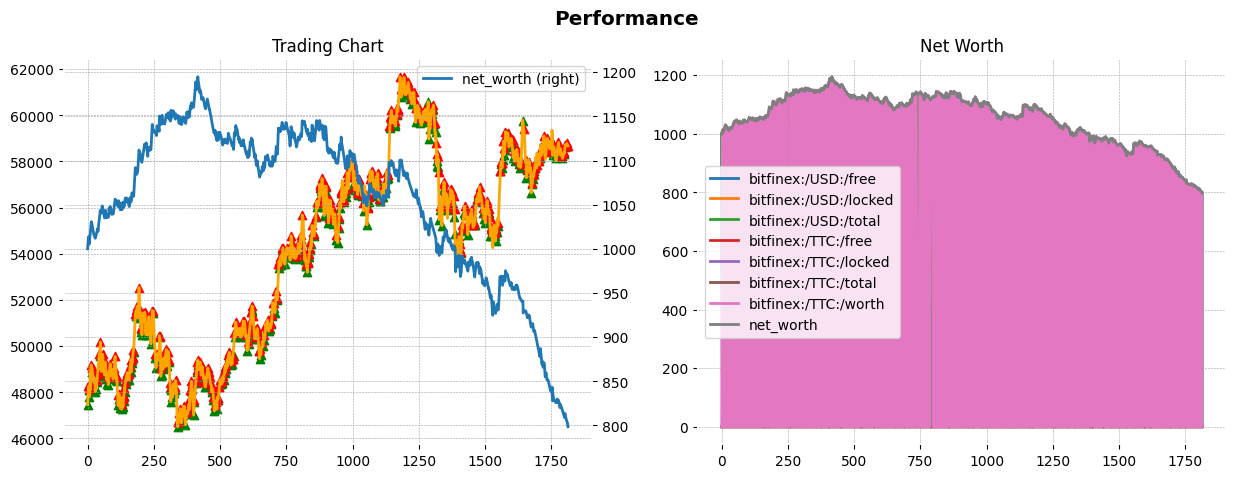

Total reward = 262138.92999999988
Net worth = 798.51 USD
PNL = -20.149000000000004 %


In [43]:
evaluate_agent(agent, {"window_size": 25, "df": df})

df_sine_fixed


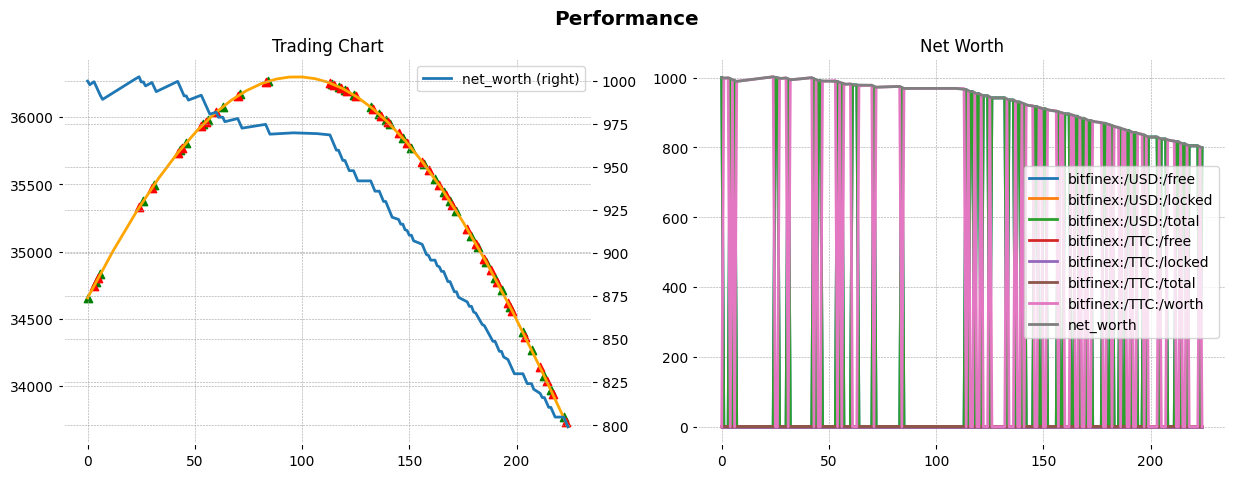

Total reward = 1246.4778134885491
Net worth = 799.14 USD
PNL = -20.086000000000006 %
df_sine_up


2021-07-20 09:12:25,648	ERROR worker.py:1074 -- Possible unhandled error from worker: ray::RolloutWorker.restore() (pid=4580, ip=172.28.0.2)
  File "python/ray/_raylet.pyx", line 479, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 432, in ray._raylet.execute_task.function_executor
  File "/usr/local/lib/python3.7/dist-packages/ray/rllib/evaluation/rollout_worker.py", line 894, in restore
    objs = pickle.loads(objs)
  File "/usr/local/lib/python3.7/dist-packages/torch/storage.py", line 142, in _load_from_bytes
    return torch.load(io.BytesIO(b))
  File "/usr/local/lib/python3.7/dist-packages/torch/serialization.py", line 585, in load
    return _legacy_load(opened_file, map_location, pickle_module, **pickle_load_args)
  File "/usr/local/lib/python3.7/dist-packages/torch/serialization.py", line 765, in _legacy_load
    result = unpickler.load()
  File "/usr/local/lib/python3.7/dist-packages/torch/serialization.py", line 721, in persistent_load
    deserialized_objec

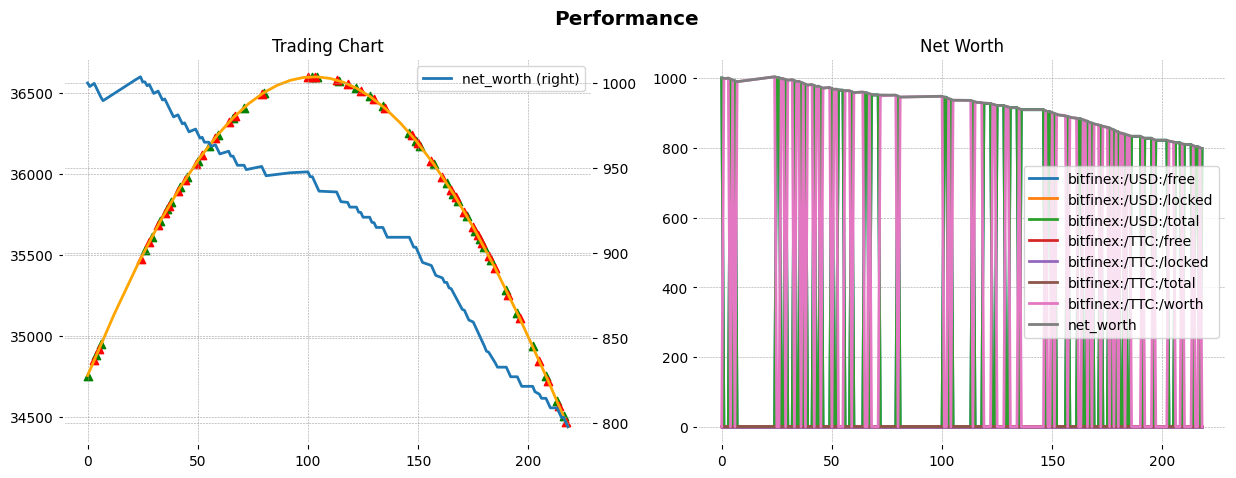

Total reward = 1326.6759661763062
Net worth = 797.92 USD
PNL = -20.208000000000006 %
df_sine_down


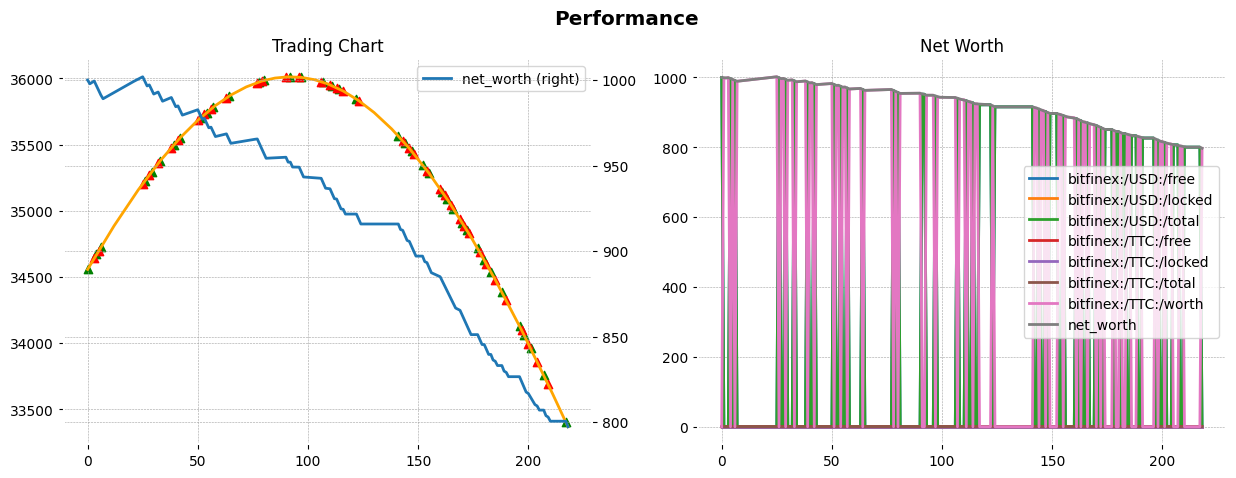

Total reward = 1527.0028679167299
Net worth = 797.2302532925495 USD
PNL = -20.27697467074505 %
df_binance_1d


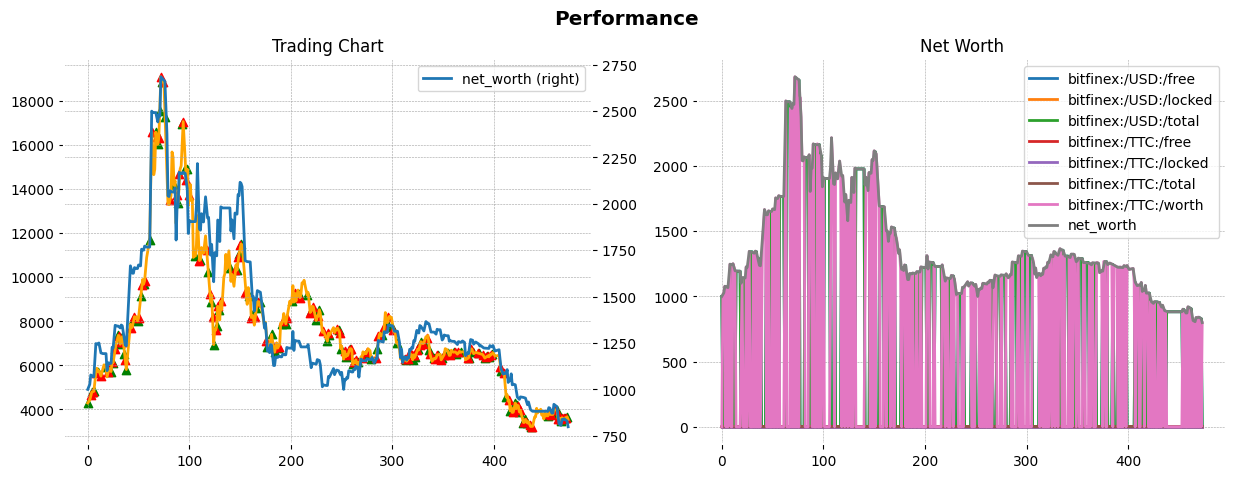

Total reward = 7758.2199999999775
Net worth = 798.6916919856001 USD
PNL = -20.13083080143999 %
df_binance_1h


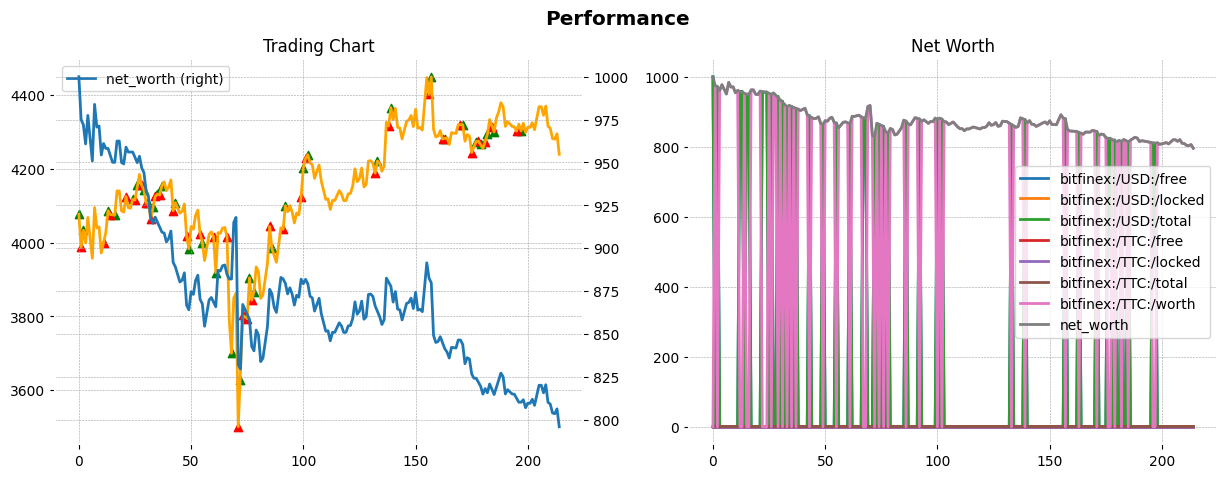

Total reward = -301.71999999999844
Net worth = 795.7864717706001 USD
PNL = -20.421352822939987 %
df_binance_15m


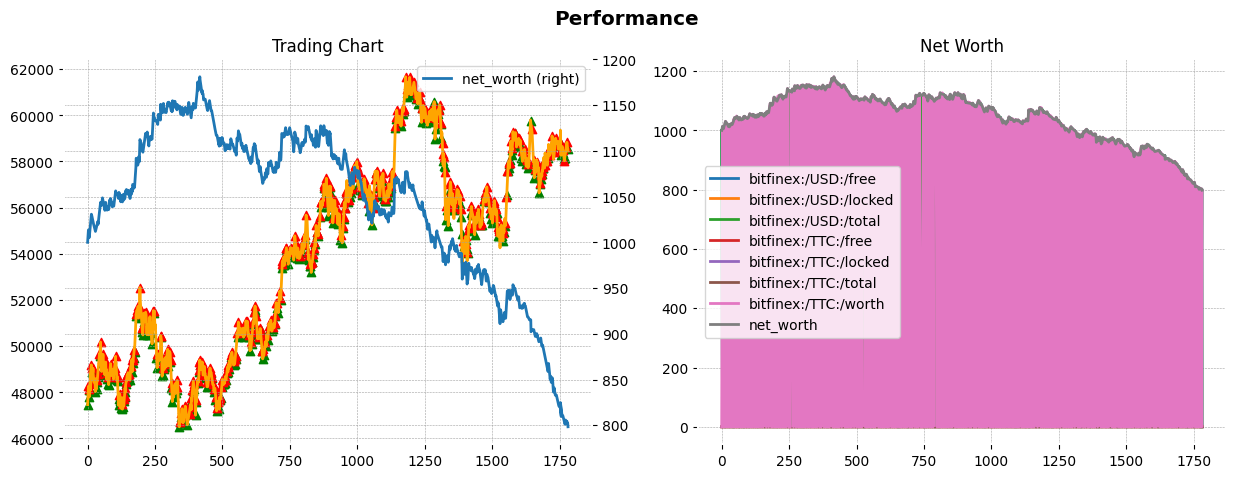

Total reward = 258796.20999999993
Net worth = 798.3296814381 USD
PNL = -20.16703185619 %


In [44]:
print('df_sine_fixed')
evaluate_agent(agent, {"window_size": 25, "df": df_sine_fixed})
print('df_sine_up')
evaluate_agent(agent, {"window_size": 25, "df": df_sine_up})
print('df_sine_down')
evaluate_agent(agent, {"window_size": 25, "df": df_sine_down})
print('df_binance_1d')
evaluate_agent(agent, {"window_size": 25, "df": df_binance_1d})
print('df_binance_1h')
evaluate_agent(agent, {"window_size": 25, "df": df_binance_1h})
print('df_binance_15m')
evaluate_agent(agent, {"window_size": 25, "df": df_binance_15m})

## Performance and Net Worth Plotting

In [45]:
def show_performance(df, price_history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    fig.suptitle('Performance')

    df.plot(ax=axs[0], grid=True, fontsize=12)
    df.net_worth.plot(ax=axs[1], grid=True, legend=True)
    price_history['close'].plot(ax=axs[1], secondary_y=True, legend=True)

    plt.interactive(True)
    plt.show(block=True)

In [46]:
def agent_performance():
  performance = pd.DataFrame.from_dict(env.action_scheme.portfolio.performance, orient='index')
  performance.drop(['bitfinex:/USD-TTC'], axis=1, inplace=True)
  #show_performance(performance, price_history)

  net_worth = performance.net_worth[len(performance.net_worth)-1]
  print(f"Net worth = {net_worth} USD")

  pnl = 100*(net_worth/initial_capital - 1)
  print(f"PNL = {pnl} %")

In [47]:
#env.action_scheme.portfolio.performance